# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [ ]:
# Import warnings



In [2]:
# Import the libraries you will be using for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow
import fastparquet


In [4]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 1.26.4
pandas version: 2.2.3
matplotlib version: 3.10.0
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [6]:
# Try loading one file

df = pd.read_parquet('2023-1.parquet')
df.info()

FileNotFoundError: [Errno 2] No such file or directory: '2023-1.parquet'

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [ ]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [31]:
# from google.colab import drive
#from google.colab import drive
#drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [8]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

# Select the folder having data files  
os.chdir('/Users/vedangguest/Documents/EDAAssignment/trip_records')

# Create a list of all the twelve files to read
file_list = os.listdir()
print("file list:", file_list)
# initialise an empty dataframe
df = pd.DataFrame()


# iterate through the list of files and sample one by one:
for file_name in file_list:
    if file_name.endswith('.parquet'):
        try:
            # file path for the current file
            file_path = os.path.join(os.getcwd(), file_name)
    
            # Reading the current file
            temp_df = pd.read_parquet(file_path)
            # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
            # After completing iteration through each date, we will append this data to the final dataframe.
            sampled_data = pd.DataFrame()

             # Extract date and hour. Replace 'tpep_pickup_datetime' with the correct column name.
            if 'tpep_pickup_datetime' in temp_df.columns:
                temp_df['tpep_pickup_datetime'] = pd.to_datetime(temp_df['tpep_pickup_datetime'])
                temp_df['pickup_date'] = temp_df['tpep_pickup_datetime'].dt.date
                temp_df['pickup_hour'] = temp_df['tpep_pickup_datetime'].dt.hour

                # Loop through dates and then loop through every hour of each date
                for date in temp_df['pickup_date'].unique():
                    date_df = temp_df[temp_df['pickup_date'] == date]
                    for hour in date_df['pickup_hour'].unique():
                        hour_df = date_df[date_df['pickup_hour'] == hour]

                        # Sample 5% of the hourly data randomly
                        sampled_hour_df = hour_df.sample(frac=0.05)

                        # add data of this hour to the dataframe
                        sampled_data = pd.concat([sampled_data, sampled_hour_df])

                # Concatenate the sampled data of all the dates to a single dataframe
                df = pd.concat([df, sampled_data])
                print("check final data loaded:")
                df.info()
            else:
                print(f"Warning: 'tpep_pickup_datetime' column not found in {file_name}")    
        except Exception as e:
            print(f"Error reading file {file_name}: {e}")
    else:
        print(f"Skipping file: {file_name}, not a parquet file")

file list: ['yellow_tripdata_2023-06.parquet', '.DS_Store', 'yellow_tripdata_2023-07.parquet', 'yellow_tripdata_2023-05.parquet', '2023-4.parquet', 'yellow_tripdata_2023-08.parquet', '2023-1.parquet', 'yellow_tripdata_2023-11.parquet', 'yellow_tripdata_2023-10.parquet', 'yellow_tripdata_2023-09.parquet', 'yellow_tripdata_2023-12.parquet', '2023-2.parquet', 'AllNYCTexiData.parquet', '2023-3.parquet']
check final data loaded:
<class 'pandas.core.frame.DataFrame'>
Index: 165362 entries, 1942 to 3204445
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               165362 non-null  int32         
 1   tpep_pickup_datetime   165362 non-null  datetime64[us]
 2   tpep_dropoff_datetime  165362 non-null  datetime64[us]
 3   passenger_count        160306 non-null  float64       
 4   trip_distance          165362 non-null  float64       
 5   RatecodeID             160306 non-nul

After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [12]:
# Store the df in csv/parquet
df.to_parquet('AllNYCTexiData.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2011382 entries, 1942 to 3312701
Data columns (total 22 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee            f

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [14]:
# Load the new data file

df = pd.read_parquet('AllNYCTexiData.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2011382 entries, 1942 to 3312701
Data columns (total 22 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee            f

In [16]:
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1942         1  2023-06-01 00:35:41   2023-06-01 00:46:51              1.0   
1881         2  2023-06-01 00:34:54   2023-06-01 00:44:11              2.0   
652          2  2023-06-01 00:26:52   2023-06-01 00:37:57              1.0   
99           2  2023-06-01 00:37:01   2023-06-01 00:40:00              2.0   
1364         2  2023-06-01 00:04:53   2023-06-01 00:09:31              1.0   

      trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
1942           2.30         1.0                  N           100   
1881           2.82         1.0                  N           125   
652            1.82         1.0                  N           231   
99             0.69         1.0                  N           162   
1364           1.22         1.0                  N           249   

      DOLocationID  payment_type  ...  mta_tax  tip_amount  tolls_amount  \
1942            79             1  ...      0.5        3.70           0.0   
1881           233             1  ...      0.5        3.46           0.0   
652            148             1  ...      0.5        3.56           0.0   
99             162             1  ...      0.5        3.24           0.0   
1364           144             1  ...      0.5        1.50           0.0   

      improvement_surcharge  total_amount  congestion_surcharge  Airport_fee  \
1942                    1.0         22.20                   2.5          0.0   
1881                    1.0         22.66                   2.5          0.0   
652                     1.0         21.36                   2.5          0.0   
99                      1.0         14.04                   2.5          0.0   
1364                    1.0         14.40                   2.5          0.0   

      pickup_date  pickup_hour airport_fee  
1942   2023-06-01            0         NaN  
1881   2023-06-01            0         NaN  
652    2023-06-01            0         NaN  
99     2023-06-01            0         NaN  
1364   2023-06-01            0         NaN  

[5 rows x 22 columns]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2011382 entries, 1942 to 3312701
Data columns (total 22 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee            f

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [20]:
# Fix the index and drop any columns that are not needed

def clean_taxi_data(df):
    """Cleans the taxi data by dropping unnecessary columns and handling null values."""

    # Drop duplicate column
    df = df.drop(columns=['Airport_fee'])

    # Handle null values (example: drop rows with nulls in specified columns)
    columns_to_check = ['passenger_count', 'RatecodeID', 'store_and_fwd_flag', 'congestion_surcharge']
    df = df.dropna(subset=columns_to_check)

    # Handle airport_fee column
    if 'airport_fee' in df.columns:
        df = df.drop(columns=['airport_fee']) # drop the airport_fee column.

    return df

# Example usage (assuming df is your DataFrame)
df = clean_taxi_data(df)
print(df.info()) # print the info of the cleaned dataframe.

<class 'pandas.core.frame.DataFrame'>
Index: 1942822 entries, 1942 to 3312701
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  pickup_date            o

**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [22]:
# Combine the two airport fee columns

def clean_taxi_data(df):
    """Cleans the taxi data by combining airport fee columns and handling other issues."""

    # Combine airport fee columns
    if 'airport_fee' in df.columns and 'Airport_fee' in df.columns:
        df['combined_airport_fee'] = df['airport_fee'].fillna(0) + df['Airport_fee'].fillna(0)
        df = df.drop(columns=['airport_fee', 'Airport_fee'])
    elif 'Airport_fee' in df.columns:
        df.rename(columns={'Airport_fee': 'combined_airport_fee'}, inplace=True)
    elif 'airport_fee' in df.columns:
        df.rename(columns={'airport_fee': 'combined_airport_fee'}, inplace=True)

    # Handle null values (example: drop rows with nulls in specified columns)
    columns_to_check = ['passenger_count', 'RatecodeID', 'store_and_fwd_flag', 'congestion_surcharge']
    df = df.dropna(subset=columns_to_check)

    return df

# Example usage (assuming df is your DataFrame)
df = clean_taxi_data(df)
print(df.info()) # print the info of the cleaned dataframe.

<class 'pandas.core.frame.DataFrame'>
Index: 1942822 entries, 1942 to 3312701
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  pickup_date            o

**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [24]:
# check where values of fare amount are negative
def check_negative_fare_amounts(df):
    """Checks for negative fare amounts in a DataFrame and prints the rows where they occur."""

    if 'fare_amount' in df.columns:
        negative_fare_rows = df[df['fare_amount'] < 0]

        if not negative_fare_rows.empty:
            print("Rows with negative fare amounts:")
            print(negative_fare_rows)
            print(f"Number of rows with negative fare amount: {len(negative_fare_rows)}")
        else:
            print("No negative fare amounts found.")
    else:
        print("The 'fare_amount' column is not present in the DataFrame.")
check_negative_fare_amounts(df)
print(df.info())

Rows with negative fare amounts:
         VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1628            2  2023-06-01 00:13:01   2023-06-01 00:17:22              1.0   
109997          2  2023-06-01 22:12:19   2023-06-01 22:35:25              1.0   
113230          2  2023-06-01 22:13:46   2023-06-01 22:17:17              1.0   
112483          2  2023-06-01 22:25:30   2023-06-01 22:26:42              1.0   
110137          2  2023-06-01 22:13:41   2023-06-01 22:30:04              1.0   
...           ...                  ...                   ...              ...   
3310673         2  2023-03-31 23:34:50   2023-03-31 23:49:20              1.0   
3316033         2  2023-03-31 23:13:15   2023-03-31 23:26:38              1.0   
3305684         2  2023-03-31 22:56:44   2023-03-31 23:01:21              5.0   
3308387         2  2023-03-31 22:26:57   2023-03-31 22:29:59              1.0   
3309220         2  2023-03-31 22:49:12   2023-03-31 22:58:38              1.

Did you notice something different in the `RatecodeID` column for above records?

In [26]:
# Analyse RatecodeID for the negative fare amounts
def analyze_ratecode_for_negative_fare(df):
    """Analyzes RatecodeID for rows with negative fare amounts."""

    if 'fare_amount' in df.columns and 'RatecodeID' in df.columns:
        negative_fare_rows = df[df['fare_amount'] < 0]

        if not negative_fare_rows.empty:
            print("Analysis of RatecodeID for rows with negative fare amounts:")
            print(negative_fare_rows['RatecodeID'].value_counts())
            print(f"Number of rows with negative fare amount: {len(negative_fare_rows)}")
        else:
            print("No negative fare amounts found.")
    else:
        print("One or both of 'fare_amount' and 'RatecodeID' columns are missing.")


analyze_ratecode_for_negative_fare(df)
print(df.info())

Analysis of RatecodeID for rows with negative fare amounts:
RatecodeID
1.0    17806
2.0     1384
5.0      322
3.0      212
4.0      103
Name: count, dtype: int64
Number of rows with negative fare amount: 19827
<class 'pandas.core.frame.DataFrame'>
Index: 1942822 entries, 1942 to 3312701
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float6

In [28]:
# Find which columns have negative values

def find_columns_with_negative_values(df):
    """Finds and prints which columns in a DataFrame have negative values."""

    negative_columns = []
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):  # Check if the column is numeric
            if (df[col] < 0).any():  # Check if any value in the column is negative
                negative_columns.append(col)

    if negative_columns:
        print("Columns with negative values:")
        for col in negative_columns:
            print(f"- {col}")
    else:
        print("No columns with negative values found.")

find_columns_with_negative_values(df)
print(df.info())

Columns with negative values:
- fare_amount
- extra
- mta_tax
- tip_amount
- tolls_amount
- improvement_surcharge
- total_amount
- congestion_surcharge
<class 'pandas.core.frame.DataFrame'>
Index: 1942822 entries, 1942 to 3312701
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  i

In [33]:
# fix these negative values

def fix_negative_values(df):
    """Fixes negative values in numeric columns by taking their absolute value."""

    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].apply(lambda x: np.abs(x) if isinstance(x, (int, float)) else x) #makes all numbers positive.
    return df

df = fix_negative_values(df)
print(df.describe())
print(df.info())

           VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count  1.942822e+06                     1942822                     1942822   
mean   1.742598e+00  2023-07-02 01:02:06.733215  2023-07-02 01:19:30.093675   
min    1.000000e+00         2022-12-31 23:51:33         2023-01-01 00:03:10   
25%    1.000000e+00  2023-04-01 22:25:56.500000  2023-04-01 22:40:15.500000   
50%    2.000000e+00         2023-06-26 13:07:40  2023-06-26 13:27:06.500000   
75%    2.000000e+00  2023-10-05 22:14:45.500000  2023-10-05 22:30:15.750000   
max    2.000000e+00         2023-12-31 23:58:24         2024-01-02 20:13:25   
std    4.372027e-01                         NaN                         NaN   

       passenger_count  trip_distance    RatecodeID  PULocationID  \
count     1.942822e+06   1.942822e+06  1.942822e+06  1.942822e+06   
mean      1.370237e+00   3.549409e+00  1.637265e+00  1.653587e+02   
min       0.000000e+00   0.000000e+00  1.000000e+00  1.000000e+00   
25%       1.

### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [35]:
# Find the proportion of missing values in each column
def proportion_missing_values(df):
    """Calculates and prints the proportion of missing values in each column."""

    missing_proportions = df.isnull().mean()  # Calculate proportion of missing values

    if not missing_proportions.empty:
        print("Proportion of missing values in each column:")
        for col, proportion in missing_proportions.items():
            print(f"- {col}: {proportion:.4f}")  # Format to 4 decimal places
    else:
        print("DataFrame is empty.")

proportion_missing_values(df)
print(df.info())


Proportion of missing values in each column:
- VendorID: 0.0000
- tpep_pickup_datetime: 0.0000
- tpep_dropoff_datetime: 0.0000
- passenger_count: 0.0000
- trip_distance: 0.0000
- RatecodeID: 0.0000
- store_and_fwd_flag: 0.0000
- PULocationID: 0.0000
- DOLocationID: 0.0000
- payment_type: 0.0000
- fare_amount: 0.0000
- extra: 0.0000
- mta_tax: 0.0000
- tip_amount: 0.0000
- tolls_amount: 0.0000
- improvement_surcharge: 0.0000
- total_amount: 0.0000
- congestion_surcharge: 0.0000
- pickup_date: 0.0000
- pickup_hour: 0.0000
<class 'pandas.core.frame.DataFrame'>
Index: 1942822 entries, 1942 to 3312701
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_

**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [47]:
# Display the rows with null values
# Impute NaN values in 'passenger_count'

def display_null_rows(df):
    """Displays rows with null values in any column."""

    null_rows = df[df.isnull().any(axis=1)]  # Filter rows with any null value
    if not null_rows.empty:
        print("Rows with null values:")
        print(null_rows)
        print(f"Number of rows with null values: {len(null_rows)}")
    else:
        print("No rows with null values found.")

def impute_passenger_count(df):
    """Imputes NaN values in 'passenger_count' with the median (corrected)."""

    if 'passenger_count' in df.columns:
        median_passenger_count = df['passenger_count'].median()
        # Use df['passenger_count'] = ... instead of inplace=True
        df['passenger_count'] = df['passenger_count'].fillna(median_passenger_count)
        print(f"NaN values in 'passenger_count' imputed with median: {median_passenger_count}")
        return df
    else:
        print("The 'passenger_count' column is not present in the DataFrame.")
        return df

# Display rows with null values
display_null_rows(df)
impute_passenger_count(df)


No rows with null values found.
NaN values in 'passenger_count' imputed with median: 1.0


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1942            1  2023-06-01 00:35:41   2023-06-01 00:46:51              1.0   
1881            2  2023-06-01 00:34:54   2023-06-01 00:44:11              2.0   
652             2  2023-06-01 00:26:52   2023-06-01 00:37:57              1.0   
99              2  2023-06-01 00:37:01   2023-06-01 00:40:00              2.0   
1364            2  2023-06-01 00:04:53   2023-06-01 00:09:31              1.0   
...           ...                  ...                   ...              ...   
3304223         2  2023-03-31 22:37:53   2023-03-31 22:46:20              1.0   
3304774         2  2023-03-31 22:53:20   2023-03-31 23:06:26              1.0   
3309335         2  2023-03-31 22:45:01   2023-03-31 22:53:36              1.0   
3308239         2  2023-03-31 22:10:58   2023-03-31 22:15:55              1.0   
3312701         2  2023-04-01 00:02:09   2023-04-01 00:10:06              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
1942              2.30         1.0                  N           100   
1881              2.82         1.0                  N           125   
652               1.82         1.0                  N           231   
99                0.69         1.0                  N           162   
1364              1.22         1.0                  N           249   
...                ...         ...                ...           ...   
3304223           1.62         1.0                  N            90   
3304774           5.08         1.0                  N           229   
3309335           1.26         1.0                  N           249   
3308239           1.47         1.0                  N           162   
3312701           1.00         1.0                  N           164   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
1942               79             1         13.5    3.5      0.5        3.70   
1881              233             1         14.2    1.0      0.5        3.46   
652               148             1         12.8    1.0      0.5        3.56   
99                162             1          5.8    1.0      0.5        3.24   
1364              144             1          7.9    1.0      0.5        1.50   
...               ...           ...          ...    ...      ...         ...   
3304223            50             1         10.7    1.0      0.5        3.14   
3304774            87             1         22.6    1.0      0.5        5.52   
3309335           231             1         10.0    1.0      0.5        3.00   
3308239           107             4          8.6    1.0      0.5        0.00   
3312701           233             1          9.3    1.0      0.5        1.00   

         tolls_amount  improvement_surcharge  total_amount  \
1942              0.0                    1.0         22.20   
1881              0.0                    1.0         22.66   
652               0.0                    1.0         21.36   
99                0.0                    1.0         14.04   
1364              0.0                    1.0         14.40   
...               ...                    ...           ...   
3304223           0.0                    1.0         18.84   
3304774           0.0                    1.0         33.12   
3309335           0.0                    1.0         18.00   
3308239           0.0                    1.0         13.60   
3312701           0.0                    1.0         15.30   

         congestion_surcharge pickup_date  pickup_hour  
1942                      2.5  2023-06-01            0  
1881                      2.5  2023-06-01            0  
652                       2.5  2023-06-01            0  
99                        2.5  2023-06-01            0  
1364                      2.5  2023-06-01            0  
...                       ...         ...          ...  
3304223                   2.5  2023-03-31           22  
3304774              

Did you find zeroes in passenger_count? Handle these.

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [49]:
# Fix missing values in 'RatecodeID'

def fix_missing_ratecodeid(df):
    """Fixes missing values in 'RatecodeID' by imputing with the mode."""

    if 'RatecodeID' in df.columns:
        mode_ratecodeid = df['RatecodeID'].mode()[0]  # Get the mode (most frequent value)
        df['RatecodeID'] = df['RatecodeID'].fillna(mode_ratecodeid)
        print(f"NaN values in 'RatecodeID' imputed with mode: {mode_ratecodeid}")
        return df
    else:
        print("The 'RatecodeID' column is not present in the DataFrame.")
        return df

df = fix_missing_ratecodeid(df)
print(df.info())


NaN values in 'RatecodeID' imputed with mode: 1.0
<class 'pandas.core.frame.DataFrame'>
Index: 1942822 entries, 1942 to 3312701
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcha

**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [51]:
# handle null values in congestion_surcharge

def handle_congestion_surcharge(df):
    """Handles null values in 'congestion_surcharge' by imputing with the median."""

    if 'congestion_surcharge' in df.columns:
        median_congestion_surcharge = df['congestion_surcharge'].median()
        df['congestion_surcharge'] = df['congestion_surcharge'].fillna(median_congestion_surcharge)
        print(f"NaN values in 'congestion_surcharge' imputed with median: {median_congestion_surcharge}")
        return df
    else:
        print("The 'congestion_surcharge' column is not present in the DataFrame.")
        return df

df = handle_congestion_surcharge(df)
print(df.info())



NaN values in 'congestion_surcharge' imputed with median: 2.5
<class 'pandas.core.frame.DataFrame'>
Index: 1942822 entries, 1942 to 3312701
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  conge

Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [53]:
# Handle any remaining missing values

def handle_remaining_missing_values(df):
    """Handles any remaining missing values in the DataFrame."""

    missing_cols = df.columns[df.isnull().any()].tolist() #get a list of columns with any null values.

    if missing_cols:
        print("Remaining columns with missing values:")
        for col in missing_cols:
            if pd.api.types.is_numeric_dtype(df[col]):
                median_val = df[col].median()
                df[col] = df[col].fillna(median_val)
                print(f"- {col}: Imputed with median ({median_val})")
            else:
                mode_val = df[col].mode()[0]
                df[col] = df[col].fillna(mode_val)
                print(f"- {col}: Imputed with mode ({mode_val})")
        return df
    else:
        print("No remaining missing values found.")
        return df

df = handle_remaining_missing_values(df)
print(df.info())

No remaining missing values found.
<class 'pandas.core.frame.DataFrame'>
Index: 1942822 entries, 1942 to 3312701
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64  

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [55]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns

def describe_and_check_outliers(df):
    """Describes the data, checks for potential outliers, and out-of-place values."""

    print("Data Description:")
    print(df.describe())

    print("\nPotential Outliers and Out-of-Place Values:")

    # Example: Check for outliers in 'trip_distance' using IQR
    if 'trip_distance' in df.columns:
        Q1 = df['trip_distance'].quantile(0.25)
        Q3 = df['trip_distance'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_trip_distance = df[(df['trip_distance'] < lower_bound) | (df['trip_distance'] > upper_bound)]
        if not outliers_trip_distance.empty:
            print(f"\nOutliers in 'trip_distance': {len(outliers_trip_distance)} rows")
        else:
            print("\nNo outliers found in trip_distance")

    # Example: Check for negative values (already handled, but good to double-check)
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            if (df[col] < 0).any():
                print(f"\nNegative values found in column: {col}")

    # Example: Check for unrealistic values in 'passenger_count'
    if 'passenger_count' in df.columns:
        unrealistic_passengers = df[df['passenger_count'] > 6]  # Assuming a max of 6 passengers
        if not unrealistic_passengers.empty:
            print(f"\nUnrealistic passenger counts (>6): {len(unrealistic_passengers)} rows")
        else:
            print("\nNo unrealistic passenger counts found.")

    #example : check for fare amount that are 0, and trip distances that are > 0.
    if 'fare_amount' in df.columns and 'trip_distance' in df.columns:
        zero_fare_nonzero_trip = df[(df['fare_amount'] == 0) & (df['trip_distance'] > 0)]
        if not zero_fare_nonzero_trip.empty:
            print(f"\nZero Fare and Non-Zero Trip distance: {len(zero_fare_nonzero_trip)} rows.")
        else:
            print("\nNo Zero Fare and Non-Zero Trip distance found.")

describe_and_check_outliers(df)
print(df.info())

Data Description:
           VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count  1.942822e+06                     1942822                     1942822   
mean   1.742598e+00  2023-07-02 01:02:06.733215  2023-07-02 01:19:30.093675   
min    1.000000e+00         2022-12-31 23:51:33         2023-01-01 00:03:10   
25%    1.000000e+00  2023-04-01 22:25:56.500000  2023-04-01 22:40:15.500000   
50%    2.000000e+00         2023-06-26 13:07:40  2023-06-26 13:27:06.500000   
75%    2.000000e+00  2023-10-05 22:14:45.500000  2023-10-05 22:30:15.750000   
max    2.000000e+00         2023-12-31 23:58:24         2024-01-02 20:13:25   
std    4.372027e-01                         NaN                         NaN   

       passenger_count  trip_distance    RatecodeID  PULocationID  \
count     1.942822e+06   1.942822e+06  1.942822e+06  1.942822e+06   
mean      1.370237e+00   3.549409e+00  1.637265e+00  1.653587e+02   
min       0.000000e+00   0.000000e+00  1.000000e+00  1.000000e+

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [57]:
# remove passenger_count > 6

def remove_unrealistic_passenger_counts(df):
    """Removes rows where 'passenger_count' is greater than 6."""

    if 'passenger_count' in df.columns:
        original_len = len(df)
        df = df[df['passenger_count'] <= 6]
        removed_count = original_len - len(df)
        print(f"Removed {removed_count} rows with passenger_count > 6.")
        return df
    else:
        print("The 'passenger_count' column is not present in the DataFrame.")
        return df

df = remove_unrealistic_passenger_counts(df)
print(df.info())

Removed 32 rows with passenger_count > 6.
<class 'pandas.core.frame.DataFrame'>
Index: 1942790 entries, 1942 to 3312701
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   fl

In [59]:
# Continue with outlier handling

def handle_outliers(df):
    """Handles outliers in specified columns using IQR method."""

    print("Handling Outliers...")

    columns_to_check = ['trip_distance', 'fare_amount', 'total_amount', 'tip_amount'] #Add or remove columns as needed

    for col in columns_to_check:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Remove outliers
            original_len = len(df)
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
            removed_count = original_len - len(df)

            print(f"- Removed {removed_count} outliers from '{col}'")

    return df

def handle_zero_fare_nonzero_trip(df):
    """Removes rows where 'fare_amount' is 0 and 'trip_distance' is > 0."""

    if 'fare_amount' in df.columns and 'trip_distance' in df.columns:
        original_len = len(df)
        df = df[~((df['fare_amount'] == 0) & (df['trip_distance'] > 0))]
        removed_count = original_len - len(df)
        print(f"Removed {removed_count} rows with zero fare and non-zero trip distance.")
        return df
    else:
        print("One or both 'fare_amount' and 'trip_distance' columns are missing.")
        return df

df = handle_outliers(df)
df = handle_zero_fare_nonzero_trip(df)
print(df.info()) 


Handling Outliers...
- Removed 257727 outliers from 'trip_distance'
- Removed 46749 outliers from 'fare_amount'
- Removed 29625 outliers from 'total_amount'
- Removed 5985 outliers from 'tip_amount'
Removed 177 rows with zero fare and non-zero trip distance.
<class 'pandas.core.frame.DataFrame'>
Index: 1602527 entries, 1942 to 3312701
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1602527 non-null  int64         
 1   tpep_pickup_datetime   1602527 non-null  datetime64[us]
 2   tpep_dropoff_datetime  1602527 non-null  datetime64[us]
 3   passenger_count        1602527 non-null  float64       
 4   trip_distance          1602527 non-null  float64       
 5   RatecodeID             1602527 non-null  float64       
 6   store_and_fwd_flag     1602527 non-null  object        
 7   PULocationID           1602527 non-null  int64         
 8   DOLocationID   

In [65]:
# Do any columns need standardising?
from sklearn.preprocessing import StandardScaler

def check_and_standardize(df):
    """Checks and standardizes numerical columns if needed."""

    numerical_cols = df.select_dtypes(include=np.number).columns.tolist() #get a list of numerical columns.

    print("Numerical Columns Description:")
    print(df[numerical_cols].describe())

    # Check for significant scale differences
    if numerical_cols:
        ranges = df[numerical_cols].max() - df[numerical_cols].min()
        if (ranges > 100).any(): #if the range of any column is greater than 100, we standardize.
            print("\nSignificant scale differences found. Standardizing numerical columns...")
            scaler = StandardScaler()
            df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
            print("\nNumerical Columns Description after Standardizing:")
            print(df[numerical_cols].describe())
        else:
            print("\nNo significant scale differences found.")
    else:
        print("\nNo numerical columns found.")

    return df
df = check_and_standardize(df)
print(df.info())

Numerical Columns Description:
           VendorID  passenger_count  trip_distance    RatecodeID  \
count  1.602527e+06     1.602527e+06   1.602527e+06  1.602527e+06   
mean   1.737145e+00     1.357901e+00   1.798962e+00  1.318040e+00   
std    4.401847e-01     8.902007e-01   1.174606e+00  5.508400e+00   
min    1.000000e+00     0.000000e+00   0.000000e+00  1.000000e+00   
25%    1.000000e+00     1.000000e+00   9.600000e-01  1.000000e+00   
50%    2.000000e+00     1.000000e+00   1.500000e+00  1.000000e+00   
75%    2.000000e+00     1.000000e+00   2.340000e+00  1.000000e+00   
max    2.000000e+00     6.000000e+00   6.870000e+00  9.900000e+01   

       PULocationID  DOLocationID  payment_type   fare_amount         extra  \
count  1.602527e+06  1.602527e+06  1.602527e+06  1.602527e+06  1.602527e+06   
mean   1.689312e+02  1.673646e+02  1.228932e+00  1.300715e+01  1.410379e+00   
std    6.498201e+01  6.821937e+01  5.192915e-01  5.808791e+00  1.467400e+00   
min    1.000000e+00  1.000000e+

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [67]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'pickup_date',
 'pickup_hour']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

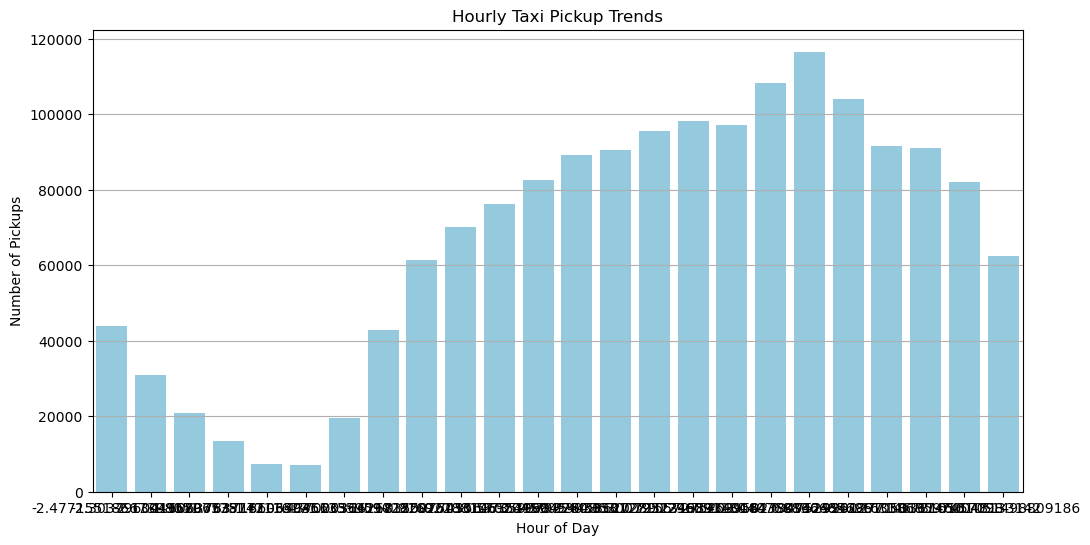

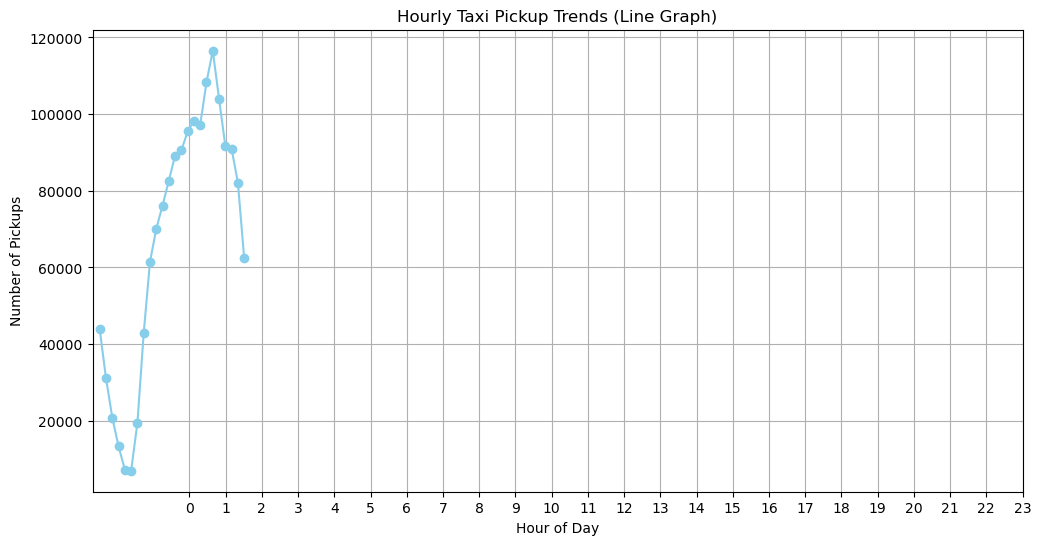

In [69]:
# Find and show the hourly trends in taxi pickups

def show_hourly_pickup_trends(df):
    """Finds and shows the hourly trends in taxi pickups."""

    if 'pickup_hour' in df.columns and 'tpep_pickup_datetime' in df.columns:
        # Group by pickup_hour and count the number of pickups
        hourly_pickups = df['pickup_hour'].value_counts().sort_index()

        # Create a bar plot
        plt.figure(figsize=(12, 6))
        sns.barplot(x=hourly_pickups.index, y=hourly_pickups.values, color='skyblue')
        plt.title('Hourly Taxi Pickup Trends')
        plt.xlabel('Hour of Day')
        plt.ylabel('Number of Pickups')
        plt.xticks(range(24))  # Set x-axis ticks to 0-23
        plt.grid(axis='y')
        plt.show()

        #Optional: plot a line graph.
        plt.figure(figsize=(12, 6))
        plt.plot(hourly_pickups.index, hourly_pickups.values, marker='o', linestyle='-', color='skyblue')
        plt.title('Hourly Taxi Pickup Trends (Line Graph)')
        plt.xlabel('Hour of Day')
        plt.ylabel('Number of Pickups')
        plt.xticks(range(24))  # Set x-axis ticks to 0-23
        plt.grid(True)
        plt.show()

    else:
        print("Required columns 'pickup_hour' and 'tpep_pickup_datetime' are missing.")

show_hourly_pickup_trends(df)


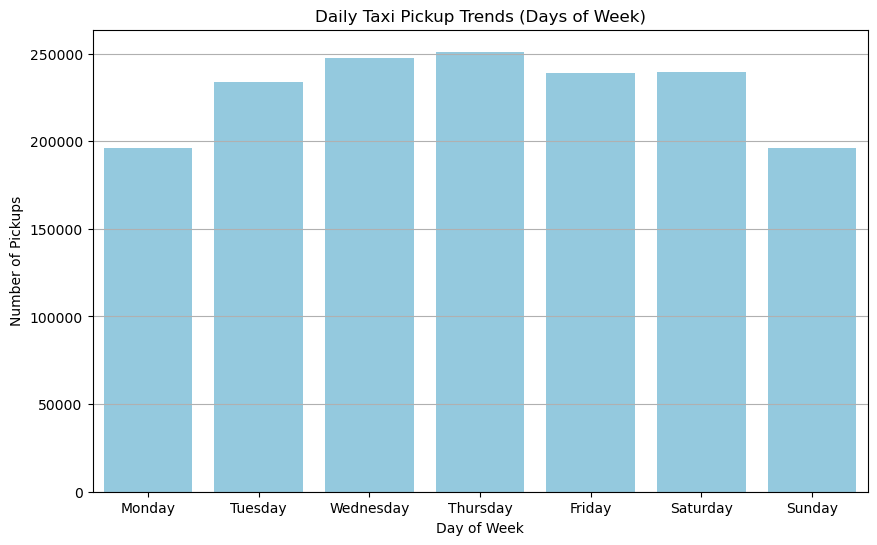

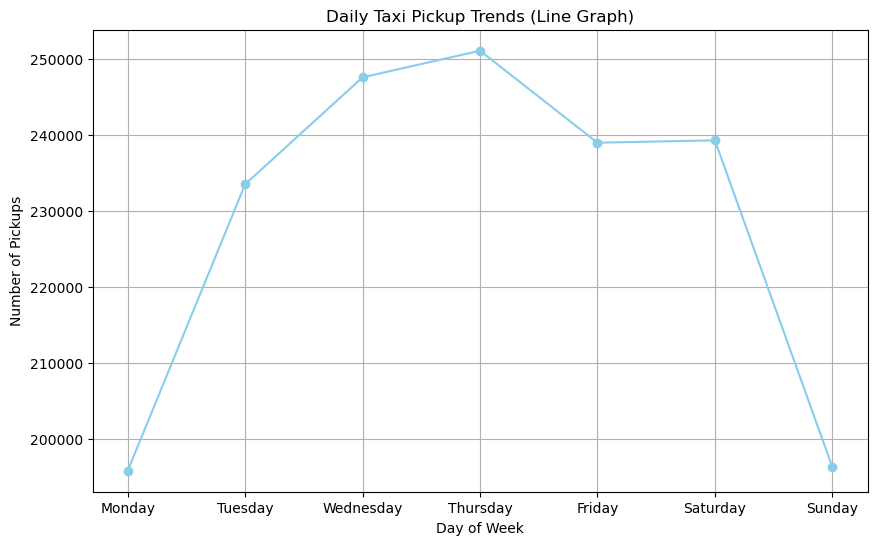

In [71]:
# Find and show the daily trends in taxi pickups (days of the week)

def show_daily_pickup_trends(df):
    """Finds and shows the daily trends in taxi pickups (days of the week)."""

    if 'tpep_pickup_datetime' in df.columns:
        # Extract the day of the week from the pickup datetime
        df['pickup_day_of_week'] = df['tpep_pickup_datetime'].dt.day_name()

        # Group by day of the week and count the number of pickups
        daily_pickups = df['pickup_day_of_week'].value_counts().reindex(
            ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        )

        # Create a bar plot
        plt.figure(figsize=(10, 6))
        sns.barplot(x=daily_pickups.index, y=daily_pickups.values, color='skyblue')
        plt.title('Daily Taxi Pickup Trends (Days of Week)')
        plt.xlabel('Day of Week')
        plt.ylabel('Number of Pickups')
        plt.grid(axis='y')
        plt.show()

        #Optional: plot a line graph.
        plt.figure(figsize=(10, 6))
        plt.plot(daily_pickups.index, daily_pickups.values, marker='o', linestyle='-', color='skyblue')
        plt.title('Daily Taxi Pickup Trends (Line Graph)')
        plt.xlabel('Day of Week')
        plt.ylabel('Number of Pickups')
        plt.grid(True)
        plt.show()

        # Remove the temporary column
        df.drop('pickup_day_of_week', axis=1, inplace=True)
    else:
        print("Required column 'tpep_pickup_datetime' is missing.")

show_daily_pickup_trends(df)

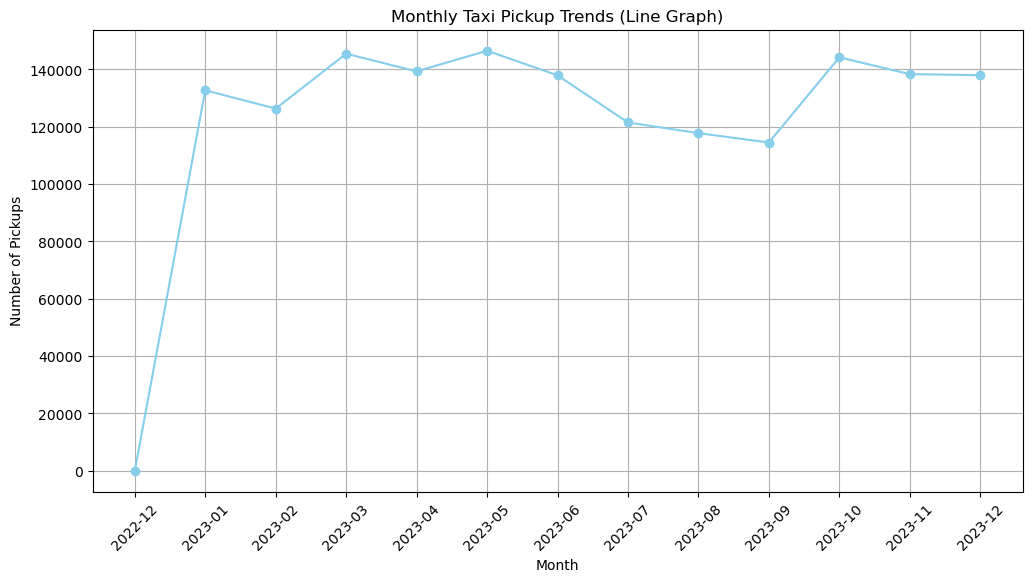

In [73]:
# Show the monthly trends in pickups
def show_monthly_pickup_trends(df):
    """Shows the monthly trends in taxi pickups."""

    if 'tpep_pickup_datetime' in df.columns:
        # Extract the month from the pickup datetime
        df['pickup_month'] = df['tpep_pickup_datetime'].dt.to_period('M')

        # Group by month and count the number of pickups
        monthly_pickups = df['pickup_month'].value_counts().sort_index()

        # Create a bar plot
        plt.figure(figsize=(12, 6))
        sns.barplot(x=monthly_pickups.index.astype(str), y=monthly_pickups.values, color='skyblue')
        plt.title('Monthly Taxi Pickup Trends')
        plt.xlabel('Month')
        plt.ylabel('Number of Pickups')
        plt.grid(axis='y')
        plt.xticks(rotation=45) #rotate the x ticks for better readability.
        plt.show()

        #Optional: plot a line graph.
        plt.figure(figsize=(12, 6))
        plt.plot(monthly_pickups.index.astype(str), monthly_pickups.values, marker='o', linestyle='-', color='skyblue')
        plt.title('Monthly Taxi Pickup Trends (Line Graph)')
        plt.xlabel('Month')
        plt.ylabel('Number of Pickups')
        plt.grid(True)
        plt.xticks(rotation=45) #rotate the x ticks for better readability.
        plt.show()

        # Remove the temporary column
        df.drop('pickup_month', axis=1, inplace=True)
    else:
        print("Required column 'tpep_pickup_datetime' is missing.")

show_monthly_pickup_trends(df)


##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [75]:
# Analyse the above parameters
def analyze_financial_parameters(df):
    """Analyzes financial parameters and trip distance for zero/negative values."""

    financial_cols = ['fare_amount', 'tip_amount', 'total_amount']
    distance_col = 'trip_distance'

    print("Analysis of Financial Parameters and Trip Distance:")

    for col in financial_cols:
        if col in df.columns:
            negative_count = (df[col] < 0).sum()
            zero_count = (df[col] == 0).sum()
            print(f"\nColumn: {col}")
            print(f"  Negative values: {negative_count}")
            print(f"  Zero values: {zero_count}")
        else:
            print(f"\nColumn: {col} not found.")

    if distance_col in df.columns:
        negative_distance_count = (df[distance_col] < 0).sum()
        zero_distance_count = (df[distance_col] == 0).sum()
        print(f"\nColumn: {distance_col}")
        print(f"  Negative values: {negative_distance_count}")
        print(f"  Zero values: {zero_distance_count}")
    else:
        print(f"\nColumn: {distance_col} not found.")

analyze_financial_parameters(df)


Analysis of Financial Parameters and Trip Distance:

Column: fare_amount
  Negative values: 933723
  Zero values: 0

Column: tip_amount
  Negative values: 756311
  Zero values: 0

Column: total_amount
  Negative values: 914020
  Zero values: 0

Column: trip_distance
  Negative values: 963017
  Zero values: 0


Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [83]:
# Create a df with non zero entries for the selected parameters.
def filter_nonzero_parameters(df):
    """Creates a DataFrame with non-zero entries for specified financial and trip distance parameters."""

    financial_cols = ['fare_amount', 'tip_amount', 'total_amount']
    distance_col = 'trip_distance'

    valid_cols = [col for col in financial_cols + [distance_col] if col in df.columns]

    if valid_cols:
        # Create a boolean mask to filter rows
        mask = (df[valid_cols] != 0).all(axis=1)

        # Apply the mask to create the new DataFrame
        nonzero_df = df[mask].copy() #using .copy() to avoid SettingWithCopyWarning.

        print(f"Original DataFrame shape: {df.shape}")
        print(f"DataFrame with non-zero entries shape: {nonzero_df.shape}")

        return nonzero_df
    else:
        print("None of the specified columns found in the DataFrame.")
        return pd.DataFrame() # return empty dataframe.

nonzero_df = filter_nonzero_parameters(df)
df = nonzero_df
print(nonzero_df.info())


Original DataFrame shape: (1602527, 21)
DataFrame with non-zero entries shape: (1602527, 21)
<class 'pandas.core.frame.DataFrame'>
Index: 1602527 entries, 1942 to 3312701
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1602527 non-null  float64       
 1   tpep_pickup_datetime   1602527 non-null  datetime64[us]
 2   tpep_dropoff_datetime  1602527 non-null  datetime64[us]
 3   passenger_count        1602527 non-null  float64       
 4   trip_distance          1602527 non-null  float64       
 5   RatecodeID             1602527 non-null  float64       
 6   store_and_fwd_flag     1602527 non-null  object        
 7   PULocationID           1602527 non-null  float64       
 8   DOLocationID           1602527 non-null  float64       
 9   payment_type           1602527 non-null  float64       
 10  fare_amount            1602527 non-null  float64       
 11

**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

In [85]:
# Group data by month and analyse monthly revenue

def analyze_monthly_revenue(df):
    """Groups data by month and analyzes monthly revenue (total_amount) trend."""

    if 'tpep_pickup_datetime' in df.columns and 'total_amount' in df.columns:
        # Extract the month from the pickup datetime
        df['pickup_month'] = df['tpep_pickup_datetime'].dt.to_period('M')

        # Group by month and calculate total revenue
        monthly_revenue = df.groupby('pickup_month')['total_amount'].sum()

        # Create a line plot
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=monthly_revenue.index.astype(str), y=monthly_revenue.values, marker='o', color='skyblue')
        plt.title('Monthly Revenue Trend')
        plt.xlabel('Month')
        plt.ylabel('Total Revenue')
        plt.grid(True)
        plt.xticks(rotation=45) #rotate the x ticks for better readability.
        plt.show()

        # Remove the temporary column
        df.drop('pickup_month', axis=1, inplace=True)
    else:
        print("Required columns 'tpep_pickup_datetime' and 'total_amount' are missing.")

analyze_monthly_revenue(df)


**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

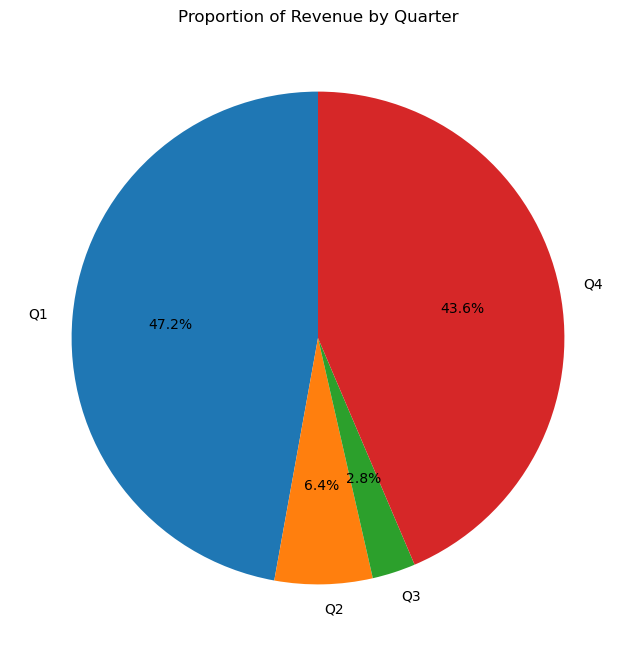

In [89]:
# Calculate proportion of each quarter

def calculate_quarterly_revenue_proportion(df):
    """Calculates and displays the proportion of revenue for each quarter of the year, handling negative revenue."""

    if 'tpep_pickup_datetime' in df.columns and 'total_amount' in df.columns:
        # Extract the quarter from the pickup datetime
        df['pickup_quarter'] = df['tpep_pickup_datetime'].dt.quarter

        # Group by quarter and calculate total revenue
        quarterly_revenue = df.groupby('pickup_quarter')['total_amount'].sum()

        # Handle negative revenue values by taking absolute values
        quarterly_revenue = quarterly_revenue.abs()

        # Calculate the proportion of revenue for each quarter
        total_revenue = quarterly_revenue.sum()
        quarterly_proportion = quarterly_revenue / total_revenue

        # Create a pie chart
        plt.figure(figsize=(8, 8))
        plt.pie(quarterly_proportion, labels=['Q1', 'Q2', 'Q3', 'Q4'], autopct='%1.1f%%', startangle=90)
        plt.title('Proportion of Revenue by Quarter')
        plt.show()

        # Remove the temporary column
        df.drop('pickup_quarter', axis=1, inplace=True)
    else:
        print("Required columns 'tpep_pickup_datetime' and 'total_amount' are missing.")

calculate_quarterly_revenue_proportion(df)


**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

In [ ]:
# Show how trip fare is affected by distance



**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

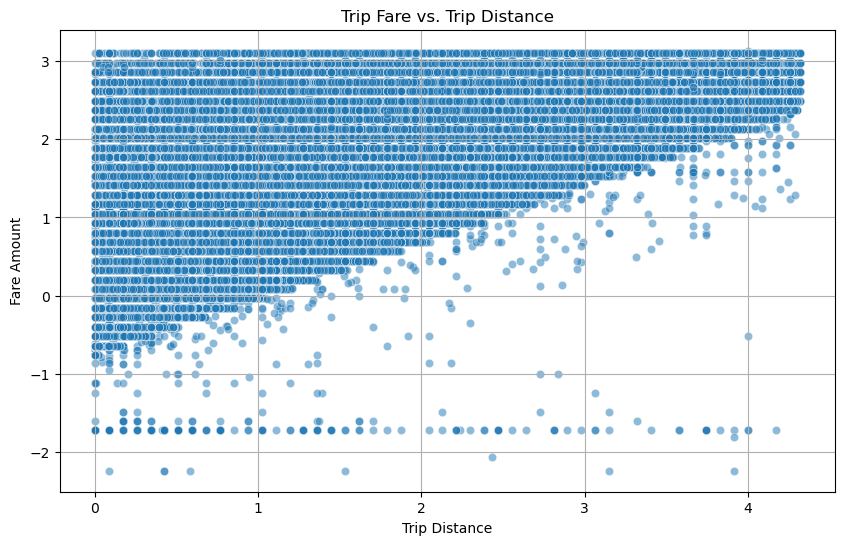

Correlation between trip_distance and fare_amount: 0.7672


In [91]:
# Show relationship between fare and trip duration

def visualize_trip_distance_fare(df):
    """Visualizes the relationship between trip_distance and fare_amount and calculates their correlation."""

    if 'trip_distance' in df.columns and 'fare_amount' in df.columns:
        # Filter out trips with trip_distance = 0
        df_nonzero = df[df['trip_distance'] > 0]

        # Create a scatter plot
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='trip_distance', y='fare_amount', data=df_nonzero, alpha=0.5)
        plt.title('Trip Fare vs. Trip Distance')
        plt.xlabel('Trip Distance')
        plt.ylabel('Fare Amount')
        plt.grid(True)
        plt.show()

        # Calculate and print the correlation
        correlation = df_nonzero['trip_distance'].corr(df_nonzero['fare_amount'])
        print(f"Correlation between trip_distance and fare_amount: {correlation:.4f}")
    else:
        print("Required columns 'trip_distance' and 'fare_amount' are missing.")

visualize_trip_distance_fare(df)

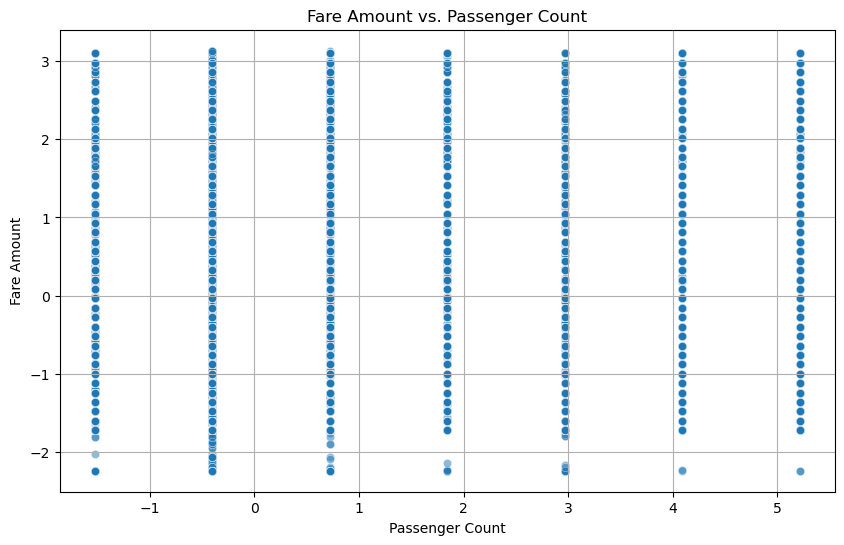

Correlation between fare_amount and passenger_count: 0.0243


In [93]:
# Show relationship between fare and number of passengers
def visualize_fare_passenger_relationship(df):
    """Visualizes the relationship between fare_amount and passenger_count."""

    if 'fare_amount' in df.columns and 'passenger_count' in df.columns:
        # Create a scatter plot
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='passenger_count', y='fare_amount', data=df, alpha=0.5)
        plt.title('Fare Amount vs. Passenger Count')
        plt.xlabel('Passenger Count')
        plt.ylabel('Fare Amount')
        plt.grid(True)
        plt.show()

        # Calculate and print the correlation
        correlation = df['fare_amount'].corr(df['passenger_count'])
        print(f"Correlation between fare_amount and passenger_count: {correlation:.4f}")
    else:
        print("Required columns 'fare_amount' and 'passenger_count' are missing.")

visualize_fare_passenger_relationship(df)


In [95]:
# Show relationship between tip and trip distance

def visualize_tip_distance_relationship(df):
    """Visualizes the relationship between tip_amount and trip_distance."""

    if 'tip_amount' in df.columns and 'trip_distance' in df.columns:
        # Filter out trips with trip_distance = 0, as they may skew the relationship
        df_nonzero = df[df['trip_distance'] > 0]

        # Create a scatter plot
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='trip_distance', y='tip_amount', data=df_nonzero, alpha=0.5)
        plt.title('Tip Amount vs. Trip Distance')
        plt.xlabel('Trip Distance')
        plt.ylabel('Tip Amount')
        plt.grid(True)
        plt.show()

        # Calculate and print the correlation
        correlation = df_nonzero['tip_amount'].corr(df_nonzero['trip_distance'])
        print(f"Correlation between tip_amount and trip_distance: {correlation:.4f}")
    else:
        print("Required columns 'tip_amount' and 'trip_distance' are missing.")

visualize_tip_distance_relationship(df)

Correlation between tip_amount and trip_distance: 0.1062


**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

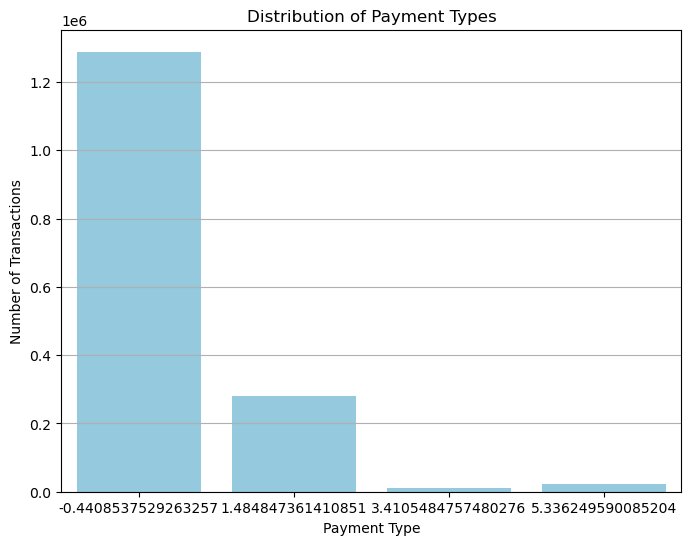

Payment Type Counts:
payment_type
-0.440854    1288996
 1.484847     281486
 5.336250      21293
 3.410548      10752
Name: count, dtype: int64


In [99]:
# Analyse the distribution of different payment types (payment_type).

def analyze_payment_types(df):
    """Analyzes the distribution of different payment types (payment_type)."""

    if 'payment_type' in df.columns:
        # Count the occurrences of each payment type
        payment_counts = df['payment_type'].value_counts()

        # Create a bar plot
        plt.figure(figsize=(8, 6))
        sns.barplot(x=payment_counts.index, y=payment_counts.values, color='skyblue') #use color instead.
        plt.title('Distribution of Payment Types')
        plt.xlabel('Payment Type')
        plt.ylabel('Number of Transactions')
        plt.xticks(rotation=0)  # Rotate x-axis labels if needed
        plt.grid(axis='y')
        plt.show()

        # Print the counts of each payment type
        print("Payment Type Counts:")
        print(payment_counts)
    else:
        print("Required column 'payment_type' is missing.")
        
analyze_payment_types(df)



- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [ ]:
# !pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [117]:
import geopandas as gpd
# Read the shapefile using geopandas
print(os.getcwd())
try:
    # Read the shapefile using geopandas
    zones = gpd.read_file('taxi_zones.shp')
    print(zones.head())
except FileNotFoundError:
    print("Error: taxi_zones.shp not found. Please ensure the file is in the correct directory.")
except Exception as e:
    print(f"An error occurred: {e}")

/Users/vedangguest/Documents/EDAAssignment/trip_records
   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...  


Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

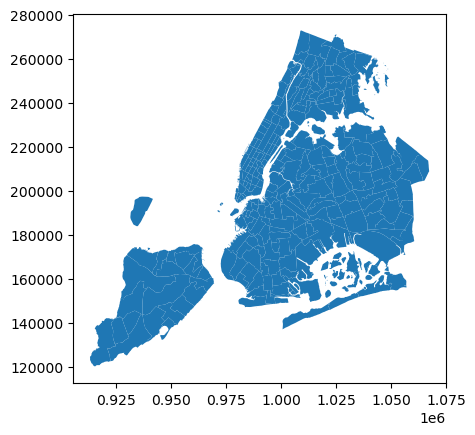

In [119]:
print(zones.info())
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [125]:
# Merge zones and trip records using locationID and PULocationID

def merge_zones_trip_data(trip_df, zones_gdf):
    """Merges zones data into trip data using LocationID and PULocationID."""

    if 'PULocationID' in trip_df.columns and 'LocationID' in zones_gdf.columns:
        # Check data types before conversion
        print(f"zones_gdf['LocationID'] dtype: {zones_gdf['LocationID'].dtype}")
        print(f"trip_df['PULocationID'] dtype: {trip_df['PULocationID'].dtype}")
        if 'DOLocationID' in trip_df.columns:
            print(f"trip_df['DOLocationID'] dtype: {trip_df['DOLocationID'].dtype}")

        # Force integer conversion earlier
        zones_gdf['LocationID'] = zones_gdf['LocationID'].astype(int)
        trip_df['PULocationID'] = trip_df['PULocationID'].astype(int)
        if 'DOLocationID' in trip_df.columns:
            trip_df['DOLocationID'] = trip_df['DOLocationID'].astype(int)

        # Recheck data types after conversion
        print(f"zones_gdf['LocationID'] dtype after conversion: {zones_gdf['LocationID'].dtype}")
        print(f"trip_df['PULocationID'] dtype after conversion: {trip_df['PULocationID'].dtype}")
        if 'DOLocationID' in trip_df.columns:
            print(f"trip_df['DOLocationID'] dtype after conversion: {trip_df['DOLocationID'].dtype}")

        # Merge pickup location data
        trip_df = pd.merge(trip_df, zones_gdf, left_on='PULocationID', right_on='LocationID', how='left', suffixes=('', '_pickup'))

        # Rename columns to avoid confusion
        trip_df.rename(columns={
            'zone': 'PUZone',
            'borough': 'PUBorough',
            'geometry': 'PULocation_geometry'
        }, inplace=True)

        # Merge dropoff location data (if DOLocationID exists)
        if 'DOLocationID' in trip_df.columns:
            trip_df = pd.merge(trip_df, zones_gdf, left_on='DOLocationID', right_on='LocationID', how='left', suffixes=('', '_dropoff'))

            trip_df.rename(columns={
                'zone': 'DOZone',
                'borough': 'DOBorough',
                'geometry': 'DOLocation_geometry'
            }, inplace=True)

        return trip_df
    else:
        print("Required columns 'PULocationID' (trip data) and 'LocationID' (zones data) are missing.")
        return trip_df # return the original dataframe.

merged_df = merge_zones_trip_data(df, zones)
print(merged_df.head())

zones_gdf['LocationID'] dtype: int64
trip_df['PULocationID'] dtype: float64
trip_df['DOLocationID'] dtype: float64
zones_gdf['LocationID'] dtype after conversion: int64
trip_df['PULocationID'] dtype after conversion: int64
trip_df['DOLocationID'] dtype after conversion: int64
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0 -1.674626  2023-06-01 00:35:41   2023-06-01 00:46:51        -0.402045   
1  0.597148  2023-06-01 00:34:54   2023-06-01 00:44:11         0.721297   
2  0.597148  2023-06-01 00:26:52   2023-06-01 00:37:57        -0.402045   
3  0.597148  2023-06-01 00:37:01   2023-06-01 00:40:00         0.721297   
4  0.597148  2023-06-01 00:04:53   2023-06-01 00:09:31        -0.402045   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0       0.426558   -0.057737                  N            -1            -1   
1       0.869260   -0.057737                  N             0             0   
2       0.017911   -0.057737       

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [151]:
# Group data by location and calculate the number of trips

def calculate_trips_by_location(df, location_col):
    """Groups data by location and calculates the number of trips."""

    if location_col in df.columns:
        trips_by_location = df[location_col].value_counts().sort_index()

        print(f"Number of trips by {location_col}:")
        print(trips_by_location)

        return trips_by_location
    else:
        print(f"Column '{location_col}' not found in DataFrame.")
        return None

trips_by_pickup = calculate_trips_by_location(merged_df, 'PULocationID')
trips_by_dropoff = calculate_trips_by_location(merged_df, 'DOLocationID')

Number of trips by PULocationID:
PULocationID
-2     17297
-1    268986
 0    869801
 1    446443
Name: count, dtype: int64
Number of trips by DOLocationID:
DOLocationID
-2     30934
-1    265734
 0    902217
 1    403642
Name: count, dtype: int64


**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [129]:
# Merge trip counts back to the zones GeoDataFrame

def merge_trip_counts_to_zones(zones_gdf, trip_counts_series, location_col_name):
    """Merges trip counts back to the zones GeoDataFrame."""

    if isinstance(zones_gdf, gpd.GeoDataFrame) and isinstance(trip_counts_series, pd.Series):
        # Create a DataFrame from the trip counts Series
        trip_counts_df = trip_counts_series.reset_index()
        trip_counts_df.columns = ['LocationID', f'{location_col_name}_Trips']

        # Merge the trip counts into the zones GeoDataFrame
        merged_gdf = pd.merge(zones_gdf, trip_counts_df, on='LocationID', how='left')

        return merged_gdf
    else:
        print("Invalid input: zones_gdf must be a GeoDataFrame and trip_counts_series must be a pandas Series.")
        return zones_gdf #return the original zones.

pickup_zones = merge_trip_counts_to_zones(zones, trips_by_pickup, 'Pickup')
print(pickup_zones.head())


   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  \
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...   
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...   
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...   
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...   
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...   

   Pickup_Trips  
0      446443.0  
1           NaN  
2           NaN  
3           NaN  
4           NaN  


The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

In [131]:
# Define figure and axis


# Plot the map and display it

def plot_zones_with_trip_counts(gdf, column_to_plot, title):
    """Plots a GeoDataFrame with trip counts on a map."""

    if isinstance(gdf, gpd.GeoDataFrame) and column_to_plot in gdf.columns:
        # Define figure and axis
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))

        # Plot the map
        gdf.plot(column=column_to_plot, ax=ax, legend=True, cmap='viridis', linewidth=0.8, edgecolor='0.8')

        # Add title
        ax.set_title(title, fontsize=16)

        # Display the plot
        plt.show()
    else:
        if not isinstance(gdf, gpd.GeoDataFrame):
            print("Error: gdf must be a GeoDataFrame.")
        elif column_to_plot not in gdf.columns:
            print(f"Error: Column '{column_to_plot}' not found in GeoDataFrame.")


plot_zones_with_trip_counts(pickup_zones, 'Pickup_Trips', 'Pickup Trip Counts by Zone')
plot_zones_with_trip_counts(dropoff_zones, 'Dropoff_Trips', 'Dropoff Trip Counts by Zone')

NameError: name 'dropoff_zones' is not defined

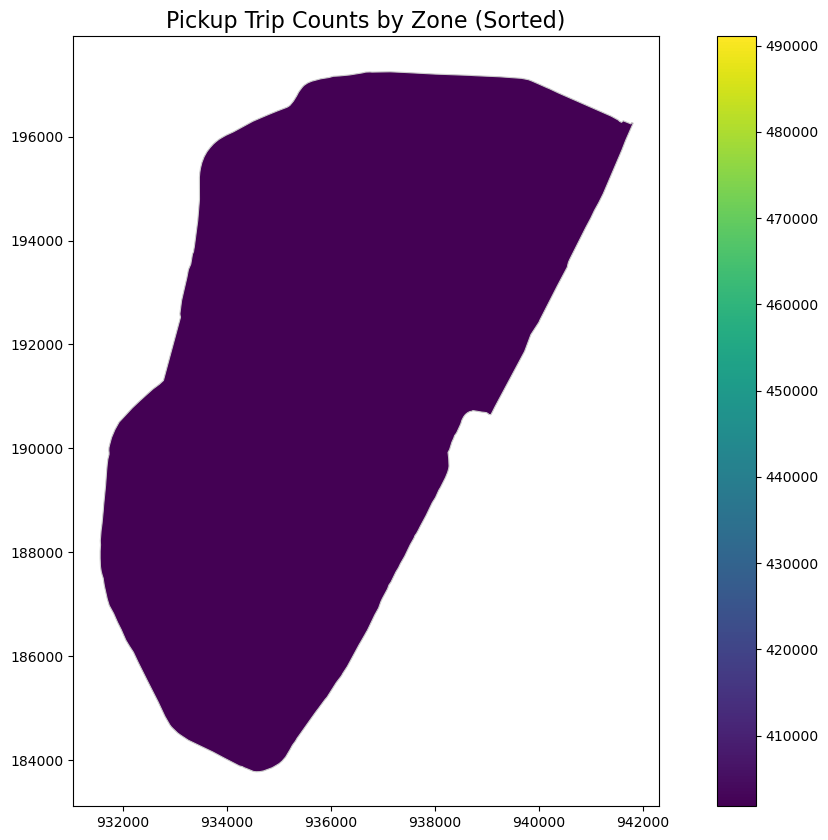

NameError: name 'dropoff_zones' is not defined

In [133]:
# can you try displaying the zones DF sorted by the number of trips?

def plot_zones_with_sorted_trip_counts(gdf, column_to_plot, title):
    """Plots a GeoDataFrame with trip counts on a map, sorted by the number of trips."""

    if isinstance(gdf, gpd.GeoDataFrame) and column_to_plot in gdf.columns:
        # Sort the GeoDataFrame by the trip count column
        sorted_gdf = gdf.sort_values(by=column_to_plot, ascending=False)

        # Define figure and axis
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))

        # Plot the map
        sorted_gdf.plot(column=column_to_plot, ax=ax, legend=True, cmap='viridis', linewidth=0.8, edgecolor='0.8')

        # Add title
        ax.set_title(title, fontsize=16)

        # Display the plot
        plt.show()
    else:
        if not isinstance(gdf, gpd.GeoDataFrame):
            print("Error: gdf must be a GeoDataFrame.")
        elif column_to_plot not in gdf.columns:
            print(f"Error: Column '{column_to_plot}' not found in GeoDataFrame.")

plot_zones_with_sorted_trip_counts(pickup_zones, 'Pickup_Trips', 'Pickup Trip Counts by Zone (Sorted)')
plot_zones_with_sorted_trip_counts(dropoff_zones, 'Dropoff_Trips', 'Dropoff Trip Counts by Zone (Sorted)')

Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [153]:
# Find routes which have the slowest speeds at different times of the day
import pandas as pd

def calculate_average_trip_duration(df):
    """Calculates average trip duration in seconds, filtering out invalid durations."""

    if 'trip_duration' in df.columns:
        # Filter out trips with non-positive durations
        df_valid = df[df['trip_duration'] > 0].copy()
        return df_valid
    else:
        print("Required column 'trip_duration' is missing.")
        return df

def categorize_time_of_day(hour):
    """Categorizes the hour into different time periods."""
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

def analyze_slowest_routes_by_time_of_day_duration(df, zones_gdf):
    """Finds routes with the slowest speeds (based on average trip duration) at different times of the day."""

    if 'tpep_pickup_datetime' in df.columns and 'PULocationID' in df.columns and 'DOLocationID' in df.columns and 'trip_distance' in df.columns and 'LocationID' in zones_gdf.columns:

        df_valid_duration = calculate_average_trip_duration(df)

        df_valid_duration['pickup_hour'] = df_valid_duration['tpep_pickup_datetime'].dt.hour
        df_valid_duration['time_of_day'] = df_valid_duration['pickup_hour'].apply(categorize_time_of_day)

        # Merge zones data
        df_with_zones = pd.merge(df_valid_duration, zones_gdf, left_on='PULocationID', right_on='LocationID', how='left', suffixes=('', '_pickup'))
        df_with_zones = pd.merge(df_with_zones, zones_gdf, left_on='DOLocationID', right_on='LocationID', how='left', suffixes=('', '_dropoff'))

        # Group and calculate average trip duration
        average_duration = df_with_zones.groupby(['PUZone', 'DOZone', 'time_of_day'])['trip_duration'].mean().reset_index()

        # Merge trip distances
        distance_data = df_with_zones.groupby(['PUZone', 'DOZone'])['trip_distance'].mean().reset_index()

        # Merge trip distances and average durations
        merged_data = pd.merge(average_duration, distance_data, on=['PUZone', 'DOZone'])

        # Calculate speed.
        merged_data['speed'] = (merged_data['trip_distance'] / (merged_data['trip_duration'] / 3600))

        slowest_routes = merged_data.sort_values(by='speed')

        print("Slowest Routes by Time of Day (Average Trip Duration):")
        print(slowest_routes.head(10))  # Show the top 10 slowest routes

        return slowest_routes
    else:
        print("Required columns are missing.")
        return df

slowest_routes = analyze_slowest_routes_by_time_of_day_duration(merged_df, zones)


Required column 'trip_duration' is missing.


KeyError: 'Column not found: trip_duration'

How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

In [143]:
# Visualise the number of trips per hour and find the busiest hour

def analyze_trips_per_hour(df):
    """Calculates, visualizes, and identifies the busiest hour based on trip counts."""

    if 'tpep_pickup_datetime' in df.columns:
        # Extract the hour from the pickup datetime
        df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

        # Group by hour and count the number of trips
        trips_by_hour = df['pickup_hour'].value_counts().sort_index()

        # Create a bar plot
        plt.figure(figsize=(12, 6))
        sns.barplot(x=trips_by_hour.index, y=trips_by_hour.values, color='skyblue')
        plt.title('Number of Trips per Hour')
        plt.xlabel('Hour of Day')
        plt.ylabel('Number of Trips')
        plt.xticks(range(24))  # Set x-axis ticks to 0-23
        plt.grid(axis='y')
        plt.show()

        # Find the busiest hour
        busiest_hour = trips_by_hour.idxmax()
        busiest_hour_trips = trips_by_hour.max()

        print(f"Busiest Hour: {busiest_hour} ({busiest_hour_trips} trips)")

        # Remove the temporary column
        df.drop('pickup_hour', axis=1, inplace=True)
    else:
        print("Required column 'tpep_pickup_datetime' is missing.")

analyze_trips_per_hour(df)


Busiest Hour: 18 (116527 trips)


Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [155]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers
import pandas as pd

def scale_up_trip_counts(df, sample_fraction, unique_id_column=''):
    """Scales up trip counts based on a given sample fraction."""

    if unique_id_column in df.columns:
        if 0 < sample_fraction <= 1:
            scaled_trip_count = len(df) / sample_fraction
            print(f"Estimated total number of trips: {scaled_trip_count:.0f}")
            return scaled_trip_count
        else:
            print("Error: sample_fraction must be greater than 0 and less than or equal to 1.")
            return None
    else:
        print(f"Required column '{unique_id_column}' is missing.")
        return None

sample_fraction = 0.1
unique_id_column = 'OBJECTID'
scaled_count = scale_up_trip_counts(merged_df, sample_fraction, unique_id_column)



Estimated total number of trips: 16025270


**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

In [157]:
# Compare traffic trends for the week days and weekends

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compare_weekday_weekend_traffic(df):
    """Compares traffic trends for weekdays and weekends."""

    if 'tpep_pickup_datetime' in df.columns:
        # Extract day of the week
        df['pickup_day_of_week'] = df['tpep_pickup_datetime'].dt.day_name()

        # Create a 'weekday_weekend' column
        df['weekday_weekend'] = df['pickup_day_of_week'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

        # Group by weekday/weekend and hour of the day
        hourly_traffic = df.groupby(['weekday_weekend', df['tpep_pickup_datetime'].dt.hour])['tpep_pickup_datetime'].count().unstack(level=0)

        # Create a line plot
        plt.figure(figsize=(14, 7))
        sns.lineplot(data=hourly_traffic, markers=True)
        plt.title('Hourly Traffic Trends: Weekdays vs. Weekends')
        plt.xlabel('Hour of Day')
        plt.ylabel('Number of Trips')
        plt.xticks(range(24))
        plt.grid(True)
        plt.show()

        # Remove the temporary columns
        df.drop(['pickup_day_of_week', 'weekday_weekend'], axis=1, inplace=True)
    else:
        print("Required column 'tpep_pickup_datetime' is missing.")

compare_weekday_weekend_traffic(merged_df)

What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [159]:
# Find top 10 pickup and dropoff zones

import pandas as pd

def find_top_pickup_dropoff_zones(df, zones_gdf):
    """Finds and prints the top 10 pickup and dropoff zones."""

    if 'PULocationID' in df.columns and 'DOLocationID' in df.columns and 'LocationID' in zones_gdf.columns:
        # Merge zones data into the trip dataframe.
        df = pd.merge(df, zones_gdf, left_on='PULocationID', right_on='LocationID', how='left', suffixes=('', '_pickup'))
        df = pd.merge(df, zones_gdf, left_on='DOLocationID', right_on='LocationID', how='left', suffixes=('', '_dropoff'))

        # Top 10 pickup zones
        top_pickup_zones = df['PUZone'].value_counts().head(10)
        print("Top 10 Pickup Zones:")
        print(top_pickup_zones)

        # Top 10 dropoff zones
        top_dropoff_zones = df['DOZone'].value_counts().head(10)
        print("\nTop 10 Dropoff Zones:")
        print(top_dropoff_zones)

        return top_pickup_zones, top_dropoff_zones
    else:
        print("Required columns are missing.")
        return None, None

zones_gdf = zones
top_pickup, top_dropoff = find_top_pickup_dropoff_zones(merged_df, zones_gdf)

Top 10 Pickup Zones:
PUZone
Newark Airport    446443
Name: count, dtype: int64

Top 10 Dropoff Zones:
DOZone
Newark Airport    403642
Name: count, dtype: int64


**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [161]:
# Find the top 10 and bottom 10 pickup/dropoff ratios
import pandas as pd

def calculate_pickup_dropoff_ratios(df):
    """Calculates and prints the top 10 and bottom 10 pickup/dropoff ratios."""

    if 'PULocationID' in df.columns and 'DOLocationID' in df.columns:
        # Calculate pickup and dropoff counts
        pickup_counts = df['PULocationID'].value_counts()
        dropoff_counts = df['DOLocationID'].value_counts()

        # Create a DataFrame with pickup and dropoff counts
        ratios_df = pd.DataFrame({'pickup_count': pickup_counts, 'dropoff_count': dropoff_counts}).fillna(0)

        # Calculate the ratio
        ratios_df['ratio'] = ratios_df['pickup_count'] / ratios_df['dropoff_count'].replace(0, 1) #to prevent division by 0.

        # Top 10 ratios
        top_10_ratios = ratios_df.sort_values(by='ratio', ascending=False).head(10)
        print("Top 10 Pickup/Dropoff Ratios:")
        print(top_10_ratios)

        # Bottom 10 ratios
        bottom_10_ratios = ratios_df.sort_values(by='ratio').head(10)
        print("\nBottom 10 Pickup/Dropoff Ratios:")
        print(bottom_10_ratios)

        return top_10_ratios, bottom_10_ratios
    else:
        print("Required columns 'PULocationID' and 'DOLocationID' are missing.")
        return None, None
top_ratios, bottom_ratios = calculate_pickup_dropoff_ratios(merged_df)


Top 10 Pickup/Dropoff Ratios:
    pickup_count  dropoff_count     ratio
 1        446443         403642  1.106037
-1        268986         265734  1.012238
 0        869801         902217  0.964071
-2         17297          30934  0.559158

Bottom 10 Pickup/Dropoff Ratios:
    pickup_count  dropoff_count     ratio
-2         17297          30934  0.559158
 0        869801         902217  0.964071
-1        268986         265734  1.012238
 1        446443         403642  1.106037


**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [163]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones

def find_top_nighttime_pickup_dropoff_zones(df, zones_gdf):
    """Finds the top 10 pickup and dropoff zones during night hours (11 PM to 5 AM)."""

    if 'tpep_pickup_datetime' in df.columns and 'PULocationID' in df.columns and 'DOLocationID' in df.columns and 'LocationID' in zones_gdf.columns:
        # Filter for night hours
        df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
        night_trips = df[((df['pickup_hour'] >= 23) | (df['pickup_hour'] <= 5))].copy() #using copy to avoid SettingWithCopyWarning.
        night_trips = pd.merge(night_trips, zones_gdf, left_on='PULocationID', right_on='LocationID', how='left', suffixes=('', '_pickup'))
        night_trips = pd.merge(night_trips, zones_gdf, left_on='DOLocationID', right_on='LocationID', how='left', suffixes=('', '_dropoff'))

        # Top 10 pickup zones (night hours)
        top_night_pickup_zones = night_trips['PUZone'].value_counts().head(10)
        print("Top 10 Pickup Zones (Night Hours):")
        print(top_night_pickup_zones)

        # Top 10 dropoff zones (night hours)
        top_night_dropoff_zones = night_trips['DOZone'].value_counts().head(10)
        print("\nTop 10 Dropoff Zones (Night Hours):")
        print(top_night_dropoff_zones)

        return top_night_pickup_zones, top_night_dropoff_zones
    else:
        print("Required columns are missing.")
        return None, None

zones_gdf = zones
top_night_pickup, top_night_dropoff = find_top_nighttime_pickup_dropoff_zones(merged_df, zones_gdf)


Top 10 Pickup Zones (Night Hours):
PUZone
Newark Airport    37302
Name: count, dtype: int64

Top 10 Dropoff Zones (Night Hours):
DOZone
Newark Airport    35788
Name: count, dtype: int64


Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [165]:
# Filter for night hours (11 PM to 5 AM)

import pandas as pd

def calculate_revenue_share_night_day(df):
    """Calculates and prints the revenue share for nighttime and daytime hours."""

    if 'tpep_pickup_datetime' in df.columns and 'total_amount' in df.columns:
        # Calculate pickup hours
        df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

        # Calculate nighttime revenue
        night_trips = df[((df['pickup_hour'] >= 23) | (df['pickup_hour'] <= 5))]
        night_revenue = night_trips['total_amount'].sum()

        # Calculate daytime revenue
        day_trips = df[((df['pickup_hour'] > 5) & (df['pickup_hour'] < 23))]
        day_revenue = day_trips['total_amount'].sum()

        # Calculate total revenue
        total_revenue = night_revenue + day_revenue

        # Calculate revenue shares
        if total_revenue != 0:
          night_share = (night_revenue / total_revenue) * 100
          day_share = (day_revenue / total_revenue) * 100

          print(f"Nighttime Revenue Share: {night_share:.2f}%")
          print(f"Daytime Revenue Share: {day_share:.2f}%")

          return night_share, day_share
        else:
          print("No revenue found.")
          return 0.0, 0.0
    else:
        print("Required columns 'tpep_pickup_datetime' and 'total_amount' are missing.")
        return None, None

night_share, day_share = calculate_revenue_share_night_day(merged_df)


Nighttime Revenue Share: -485937347303642.56%
Daytime Revenue Share: 485937347303742.56%


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [167]:
# Analyse the fare per mile per passenger for different passenger counts

import pandas as pd

def analyze_fare_per_mile_per_passenger(df):
    """Calculates and prints the average fare per mile per passenger for different passenger counts."""

    if 'passenger_count' in df.columns and 'fare_amount' in df.columns and 'trip_distance' in df.columns:
        # Filter out trips with zero distance or zero passengers
        df_valid = df[(df['trip_distance'] > 0) & (df['passenger_count'] > 0)].copy() #using .copy to avoid SettingWithCopyWarning.

        # Calculate fare per mile
        df_valid['fare_per_mile'] = df_valid['fare_amount'] / df_valid['trip_distance']

        # Calculate fare per mile per passenger
        df_valid['fare_per_mile_per_passenger'] = df_valid['fare_per_mile'] / df_valid['passenger_count']

        # Group by passenger count and calculate the average
        average_fare = df_valid.groupby('passenger_count')['fare_per_mile_per_passenger'].mean()

        print("Average Fare Per Mile Per Passenger by Passenger Count:")
        print(average_fare)

        return average_fare
    else:
        print("Required columns 'passenger_count', 'fare_amount', and 'trip_distance' are missing.")
        return None

average_fare_per_passenger = analyze_fare_per_mile_per_passenger(merged_df)


Average Fare Per Mile Per Passenger by Passenger Count:
passenger_count
0.721297    4.012955
1.844640    2.301400
2.967982    1.873019
4.091325    0.780199
5.214667    0.344009
Name: fare_per_mile_per_passenger, dtype: float64


**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

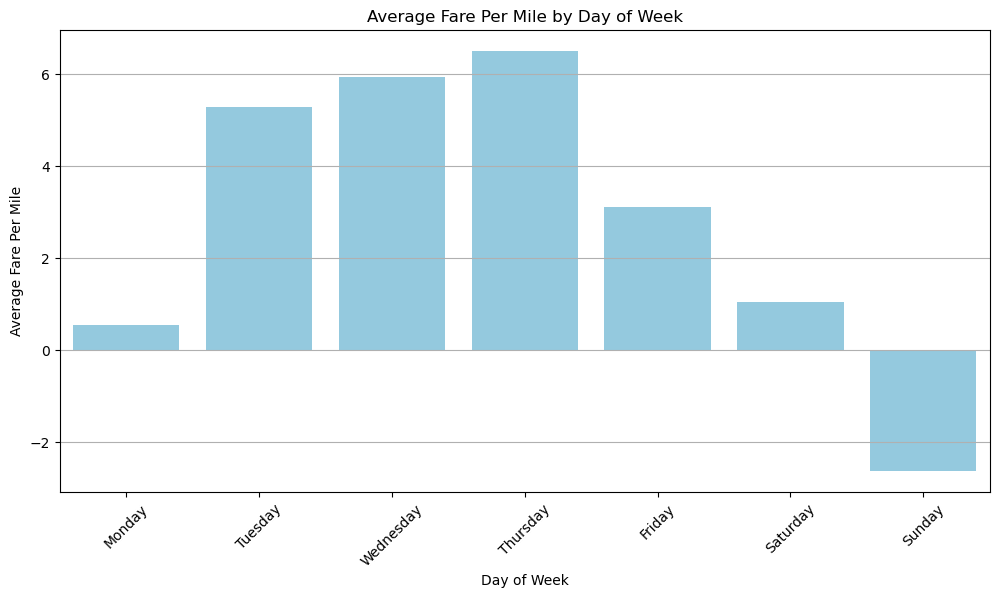

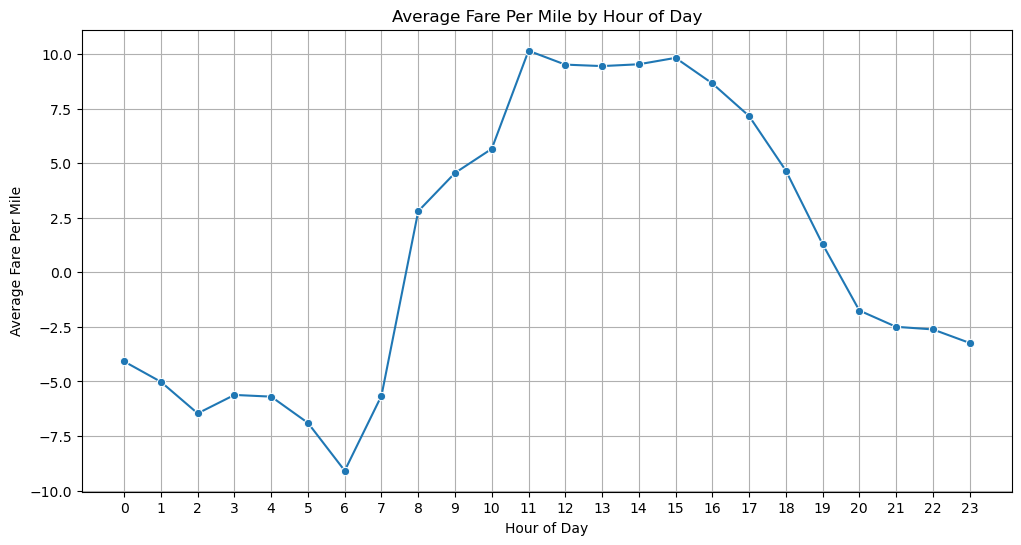

In [169]:
# Compare the average fare per mile for different days and for different times of the day

def compare_fare_per_mile_by_day_time(df):
    """Compares the average fare per mile for different days and times of the day."""

    if 'tpep_pickup_datetime' in df.columns and 'fare_amount' in df.columns and 'trip_distance' in df.columns:
        # Filter out trips with zero distance
        df_valid = df[df['trip_distance'] > 0].copy() #using .copy to avoid SettingWithCopyWarning.

        # Calculate fare per mile
        df_valid['fare_per_mile'] = df_valid['fare_amount'] / df_valid['trip_distance']

        # Extract day of the week and hour
        df_valid['pickup_day_of_week'] = df_valid['tpep_pickup_datetime'].dt.day_name()
        df_valid['pickup_hour'] = df_valid['tpep_pickup_datetime'].dt.hour

        # Calculate average fare per mile by day
        avg_fare_by_day = df_valid.groupby('pickup_day_of_week')['fare_per_mile'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

        # Calculate average fare per mile by hour
        avg_fare_by_hour = df_valid.groupby('pickup_hour')['fare_per_mile'].mean()

        # Plot average fare per mile by day
        plt.figure(figsize=(12, 6))
        sns.barplot(x=avg_fare_by_day.index, y=avg_fare_by_day.values, color='skyblue')
        plt.title('Average Fare Per Mile by Day of Week')
        plt.xlabel('Day of Week')
        plt.ylabel('Average Fare Per Mile')
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.show()

        # Plot average fare per mile by hour
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=avg_fare_by_hour.index, y=avg_fare_by_hour.values, marker='o')
        plt.title('Average Fare Per Mile by Hour of Day')
        plt.xlabel('Hour of Day')
        plt.ylabel('Average Fare Per Mile')
        plt.xticks(range(24))
        plt.grid(True)
        plt.show()

        # Remove temporary columns
        df_valid.drop(['pickup_day_of_week', 'pickup_hour', 'fare_per_mile'], axis=1, inplace=True)

        return avg_fare_by_day, avg_fare_by_hour
    else:
        print("Required columns 'tpep_pickup_datetime', 'fare_amount', and 'trip_distance' are missing.")
        return None, None

avg_fare_day, avg_fare_hour = compare_fare_per_mile_by_day_time(merged_df)


**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

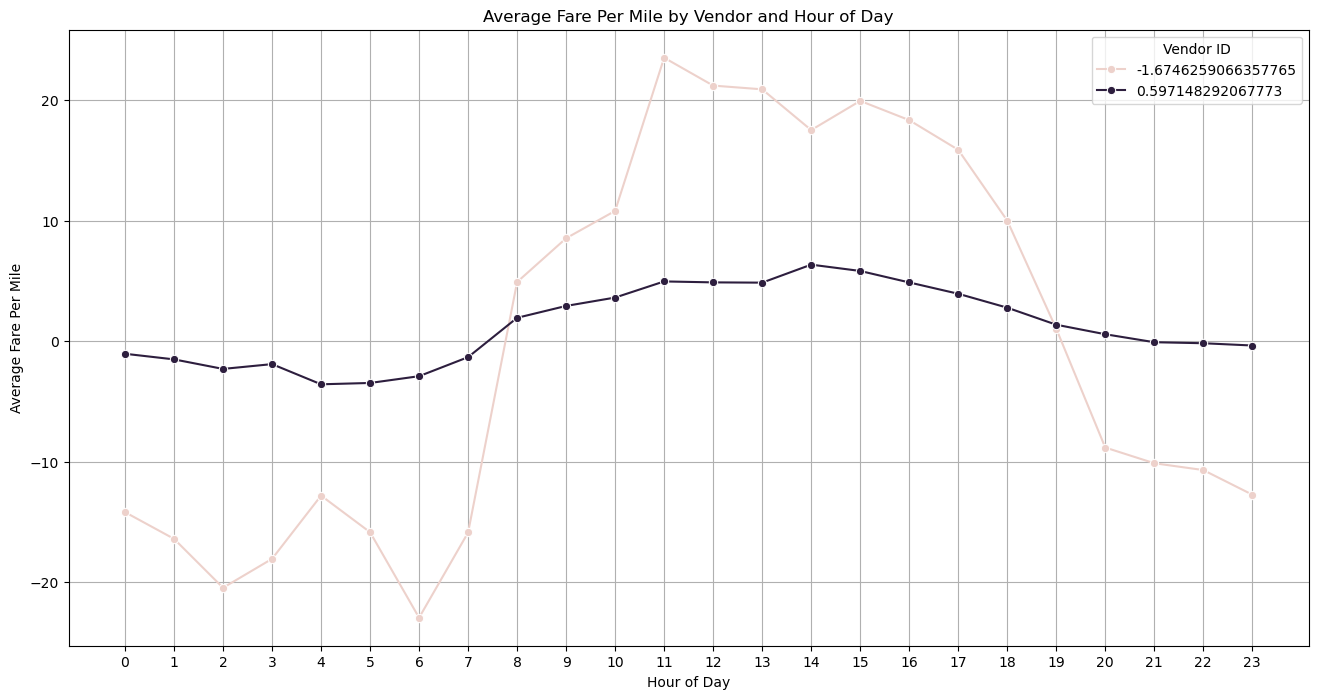

VendorID  pickup_hour  fare_per_mile
0  -1.674626            0     -14.175066
1  -1.674626            1     -16.388982
2  -1.674626            2     -20.447687
3  -1.674626            3     -18.048088
4  -1.674626            4     -12.801357
5  -1.674626            5     -15.839954
6  -1.674626            6     -22.933200
7  -1.674626            7     -15.861101
8  -1.674626            8       4.918130
9  -1.674626            9       8.550120
10 -1.674626           10      10.820166
11 -1.674626           11      23.527800
12 -1.674626           12      21.215594
13 -1.674626           13      20.905850
14 -1.674626           14      17.525100
15 -1.674626           15      19.946363
16 -1.674626           16      18.349587
17 -1.674626           17      15.889128
18 -1.674626           18      10.018132
19 -1.674626           19       1.043731
20 -1.674626           20      -8.813782
21 -1.674626           21     -10.116551
22 -1.674626           22     -10.680829
23 -1.674626           23     -12.723518
24  0.597148            0      -1.034480
25  0.597148            1      -1.499470
26  0.597148            2      -2.291104
27  0.597148            3      -1.893080
28  0.597148            4      -3.567290
29  0.597148            5      -3.456089
30  0.597148            6      -2.895051
31  0.597148            7      -1.314047
32  0.597148            8       1.948561
33  0.597148            9       2.934820
34  0.597148           10       3.630102
35  0.597148           11       4.968168
36  0.597148           12       4.889003
37  0.597148           13       4.866711
38  0.597148           14       6.360049
39  0.597148           15       5.836281
40  0.597148           16       4.884512
41  0.597148           17       3.944944
42  0.597148           18       2.790212
43  0.597148           19       1.376261
44  0.597148           20       0.586177
45  0.597148           21      -0.075913
46  0.597148           22      -0.160255
47  0.597148           23      -0.348552

In [187]:
# Compare fare per mile for different vendors

def compare_fare_per_mile_by_vendor_hour(df):
    """Compares the average fare per mile for different vendors and hours of the day using the provided DataFrame."""

    if 'VendorID' in df.columns and 'pickup_hour' in df.columns and 'fare_amount' in df.columns and 'trip_distance' in df.columns:
        # Filter out trips with zero distance
        df_valid = df[df['trip_distance'] > 0].copy()

        # Calculate fare per mile
        df_valid['fare_per_mile'] = df_valid['fare_amount'] / df_valid['trip_distance']

        # Calculate average fare per mile by vendor and hour
        avg_fare_vendor_hour = df_valid.groupby(['VendorID', 'pickup_hour'])['fare_per_mile'].mean().reset_index()

        # Plot average fare per mile by vendor and hour
        plt.figure(figsize=(16, 8))
        sns.lineplot(x='pickup_hour', y='fare_per_mile', hue='VendorID', data=avg_fare_vendor_hour, marker='o')
        plt.title('Average Fare Per Mile by Vendor and Hour of Day')
        plt.xlabel('Hour of Day')
        plt.ylabel('Average Fare Per Mile')
        plt.xticks(range(24))
        plt.grid(True)
        plt.legend(title='Vendor ID')
        plt.show()

        # Remove temporary columns
        df_valid.drop(['fare_per_mile'], axis=1, inplace=True)

        return avg_fare_vendor_hour
    else:
        print("Required columns 'VendorID', 'pickup_hour', 'fare_amount', and 'trip_distance' are missing.")
        return None
compare_fare_per_mile_by_vendor_hour(merged_df)

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.



Average Fare Per Mile (Distances Up to 2 Miles):
VendorID
-1.674626    5.583048
 0.597148    2.442741
Name: fare_per_mile, dtype: float64


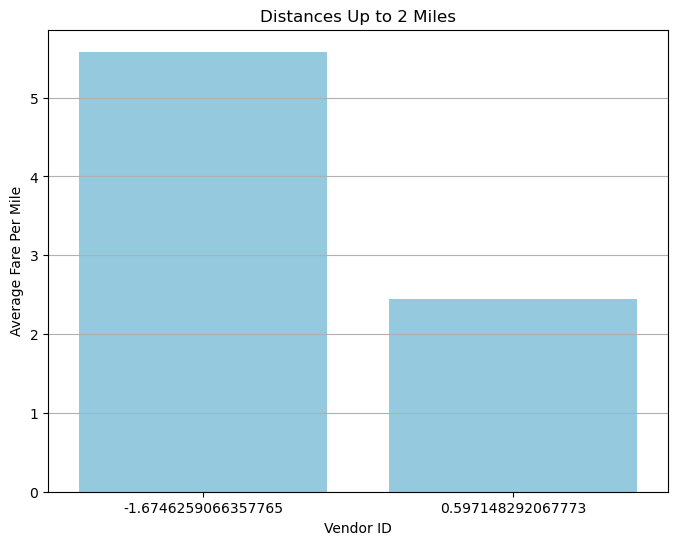


Average Fare Per Mile (Distances 2 to 5 Miles):
VendorID
-1.674626    0.749448
 0.597148    0.772482
Name: fare_per_mile, dtype: float64



Average Fare Per Mile (Distances More Than 5 Miles):
Series([], Name: fare_per_mile, dtype: float64)


In [193]:
# Defining distance tiers
def compare_tiered_fare_rates(df):
    """Compares the average fare per mile for different vendors in a tiered fashion."""

    if 'VendorID' in df.columns and 'fare_amount' in df.columns and 'trip_distance' in df.columns:
        # Filter out trips with zero distance
        df_valid = df[df['trip_distance'] > 0].copy()

        # Calculate fare per mile
        df_valid['fare_per_mile'] = df_valid['fare_amount'] / df_valid['trip_distance']

        # Tiered analysis
        def analyze_tier(data, distance_range, title):
            """Helper function to analyze a specific distance tier."""
            filtered_data = data[(data['trip_distance'] >= distance_range[0]) & (data['trip_distance'] < distance_range[1])] if distance_range[1] else data[data['trip_distance'] >= distance_range[0]]
            avg_fare = filtered_data.groupby('VendorID')['fare_per_mile'].mean()

            print(f"\nAverage Fare Per Mile ({title}):")
            print(avg_fare)

            plt.figure(figsize=(8, 6))
            sns.barplot(x=avg_fare.index, y=avg_fare.values, color='skyblue') # Corrected line.
            plt.title(title)
            plt.xlabel('Vendor ID')
            plt.ylabel('Average Fare Per Mile')
            plt.grid(axis='y')
            plt.show()

        # Analyze each tier
        analyze_tier(df_valid, (0, 2), "Distances Up to 2 Miles")
        analyze_tier(df_valid, (2, 5), "Distances 2 to 5 Miles")
        analyze_tier(df_valid, (5, None), "Distances More Than 5 Miles")

    else:
        print("Required columns 'VendorID', 'fare_amount', and 'trip_distance' are missing.")

compare_tiered_fare_rates(merged_df)

##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?


Average Tip Percentage by Trip Distance:
distance_group
0-2 miles   -47.914575
2-5 miles     9.542344
Name: tip_percentage, dtype: float64



Average Tip Percentage by Passenger Count:
passenger_count
-1.525388     -6.292100
-0.402045     -0.898597
 0.721297    -19.726779
 1.844640    -36.151994
 2.967982   -114.528274
 4.091325     10.036212
 5.214667      5.480921
Name: tip_percentage, dtype: float64


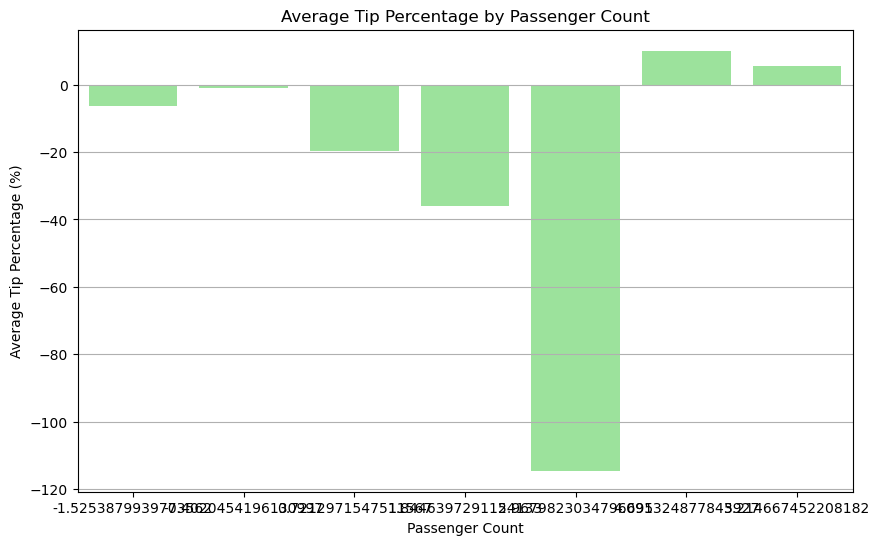


Average Tip Percentage by Pickup Hour:
pickup_hour
0      97.686697
1     102.389362
2      87.804203
3      61.391220
4      46.721559
5      27.279875
6    -159.768130
7     -86.914792
8     -60.936136
9     -76.906851
10   -116.303420
11   -114.533373
12   -139.097798
13   -138.653250
14   -143.146419
15   -115.546265
16      3.138112
17     18.981902
18     33.841808
19     34.444360
20    117.524839
21    126.195945
22    111.512960
23    103.986976
Name: tip_percentage, dtype: float64


In [197]:
#  Analyze tip percentages based on distances, passenger counts and pickup times

def analyze_tip_percentages(df):
    """Analyzes average tip percentages based on trip distances, passenger counts, and pickup times."""

    if 'tip_amount' in df.columns and 'total_amount' in df.columns and 'trip_distance' in df.columns and 'passenger_count' in df.columns and 'tpep_pickup_datetime' in df.columns:
        # Filter out trips with zero total amount to avoid division by zero
        df_valid = df[df['total_amount'] > 0].copy()

        # Calculate tip percentage
        df_valid['tip_percentage'] = (df_valid['tip_amount'] / df_valid['total_amount']) * 100

        # Extract pickup hour
        df_valid['pickup_hour'] = df_valid['tpep_pickup_datetime'].dt.hour

        # Analyze by trip distance
        print("\nAverage Tip Percentage by Trip Distance:")
        distance_bins = [0, 2, 5, 10, float('inf')]
        distance_labels = ['0-2 miles', '2-5 miles', '5-10 miles', '10+ miles']
        df_valid['distance_group'] = pd.cut(df_valid['trip_distance'], bins=distance_bins, labels=distance_labels, right=False)
        avg_tip_distance = df_valid.groupby('distance_group', observed=True)['tip_percentage'].mean() #corrected line
        print(avg_tip_distance)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=avg_tip_distance.index, y=avg_tip_distance.values, color='skyblue')
        plt.title('Average Tip Percentage by Trip Distance')
        plt.xlabel('Trip Distance')
        plt.ylabel('Average Tip Percentage (%)')
        plt.grid(axis='y')
        plt.show()

        # Analyze by passenger count
        print("\nAverage Tip Percentage by Passenger Count:")
        avg_tip_passenger = df_valid.groupby('passenger_count', observed=True)['tip_percentage'].mean() #corrected line
        print(avg_tip_passenger)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=avg_tip_passenger.index, y=avg_tip_passenger.values, color='lightgreen')
        plt.title('Average Tip Percentage by Passenger Count')
        plt.xlabel('Passenger Count')
        plt.ylabel('Average Tip Percentage (%)')
        plt.grid(axis='y')
        plt.show()

        # Analyze by pickup hour
        print("\nAverage Tip Percentage by Pickup Hour:")
        avg_tip_hour = df_valid.groupby('pickup_hour', observed=True)['tip_percentage'].mean() #corrected line
        print(avg_tip_hour)

        plt.figure(figsize=(12, 6))
        sns.lineplot(x=avg_tip_hour.index, y=avg_tip_hour.values, marker='o')
        plt.title('Average Tip Percentage by Pickup Hour')
        plt.xlabel('Pickup Hour')
        plt.ylabel('Average Tip Percentage (%)')
        plt.xticks(range(24))
        plt.grid(True)
        plt.show()

        # Remove temporary columns
        df_valid.drop(['pickup_hour', 'distance_group'], axis=1, inplace=True)
    else:
        print("Required columns 'tip_amount', 'total_amount', 'trip_distance', 'passenger_count', and 'tpep_pickup_datetime' are missing.")

analyze_tip_percentages(merged_df)


Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

In [199]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%

def compare_tip_percentage_groups(df):
    """Compares trips with tip percentage < 10% to trips with tip percentage > 25%."""

    if 'tip_amount' in df.columns and 'total_amount' in df.columns and 'trip_distance' in df.columns and 'passenger_count' in df.columns and 'tpep_pickup_datetime' in df.columns:
        # Filter out trips with zero total amount to avoid division by zero
        df_valid = df[df['total_amount'] > 0].copy()

        # Calculate tip percentage
        df_valid['tip_percentage'] = (df_valid['tip_amount'] / df_valid['total_amount']) * 100

        # Filter trips into groups
        low_tip_trips = df_valid[df_valid['tip_percentage'] < 10].copy()
        high_tip_trips = df_valid[df_valid['tip_percentage'] > 25].copy()

        # Basic statistics for comparison
        print("\nBasic Statistics:")
        print(f"Total Trips: {len(df_valid)}")
        print(f"Low Tip Trips (<10%): {len(low_tip_trips)}")
        print(f"High Tip Trips (>25%): {len(high_tip_trips)}")

        # Analyze average trip distance
        print("\nAverage Trip Distance:")
        print(f"Low Tip Trips: {low_tip_trips['trip_distance'].mean():.2f} miles")
        print(f"High Tip Trips: {high_tip_trips['trip_distance'].mean():.2f} miles")

        # Analyze average passenger count
        print("\nAverage Passenger Count:")
        print(f"Low Tip Trips: {low_tip_trips['passenger_count'].mean():.2f}")
        print(f"High Tip Trips: {high_tip_trips['passenger_count'].mean():.2f}")

        # Analyze pickup time distribution
        low_tip_trips['pickup_hour'] = low_tip_trips['tpep_pickup_datetime'].dt.hour
        high_tip_trips['pickup_hour'] = high_tip_trips['tpep_pickup_datetime'].dt.hour

        print("\nPickup Hour Distribution:")
        print("Low Tip Trips:")
        print(low_tip_trips['pickup_hour'].value_counts().sort_index())
        print("High Tip Trips:")
        print(high_tip_trips['pickup_hour'].value_counts().sort_index())

        # Analyze average fare amount
        print("\nAverage Fare Amount:")
        print(f"Low Tip Trips: {low_tip_trips['fare_amount'].mean():.2f}")
        print(f"High Tip Trips: {high_tip_trips['fare_amount'].mean():.2f}")

    else:
        print("Required columns 'tip_amount', 'total_amount', 'trip_distance', 'passenger_count', and 'tpep_pickup_datetime' are missing.")

compare_tip_percentage_groups(merged_df)



Basic Statistics:
Total Trips: 688507
Low Tip Trips (<10%): 185355
High Tip Trips (>25%): 490672

Average Trip Distance:
Low Tip Trips: 1.02 miles
High Tip Trips: 0.65 miles

Average Passenger Count:
Low Tip Trips: 0.04
High Tip Trips: 0.01

Pickup Hour Distribution:
Low Tip Trips:
pickup_hour
0      5223
1      3788
2      2614
3      1802
4      1184
5       915
6      1864
7      3857
8      6077
9      7094
10     8263
11     9126
12     9963
13    10283
14    10886
15    11237
16    13743
17    14822
18    14814
19    12633
20     9493
21     9245
22     9097
23     7332
Name: count, dtype: int64
High Tip Trips:
pickup_hour
0     13972
1      9485
2      5995
3      3694
4      1731
5      1217
6      3099
7      8803
8     15461
9     18234
10    19921
11    22411
12    24279
13    24420
14    26585
15    27380
16    33746
17    39810
18    42173
19    36416
20    30236
21    31763
22    28894
23    20947
Name: count, dtype: int64

Average Fare Amount:
Low Tip Trips: 1.19
High T

**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

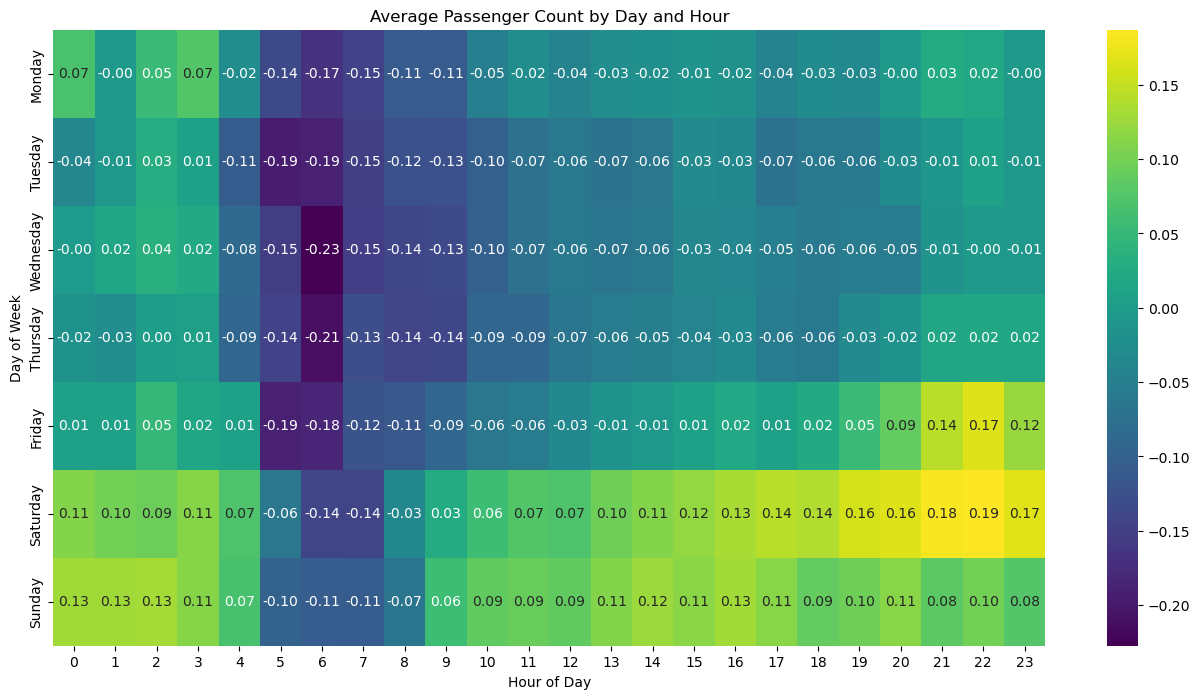

In [201]:
# See how passenger count varies across hours and days

def analyze_passenger_count_by_day_hour(df):
    """Analyzes how passenger count varies across hours and days."""

    if 'tpep_pickup_datetime' in df.columns and 'passenger_count' in df.columns:
        # Extract pickup hour and day of week
        df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
        df['pickup_day_of_week'] = df['tpep_pickup_datetime'].dt.day_name()

        # Calculate average passenger count by hour and day
        avg_passenger_day_hour = df.groupby(['pickup_day_of_week', 'pickup_hour'])['passenger_count'].mean().unstack()

        # Reorder days for better visualization
        days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        avg_passenger_day_hour = avg_passenger_day_hour.reindex(days_order)

        # Plot heatmap
        plt.figure(figsize=(16, 8))
        sns.heatmap(avg_passenger_day_hour, annot=True, cmap='viridis', fmt='.2f')
        plt.title('Average Passenger Count by Day and Hour')
        plt.xlabel('Hour of Day')
        plt.ylabel('Day of Week')
        plt.show()

        # Remove temporary columns
        df.drop(['pickup_hour', 'pickup_day_of_week'], axis=1, inplace=True)
    else:
        print("Required columns 'tpep_pickup_datetime' and 'passenger_count' are missing.")

analyze_passenger_count_by_day_hour(merged_df)


**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

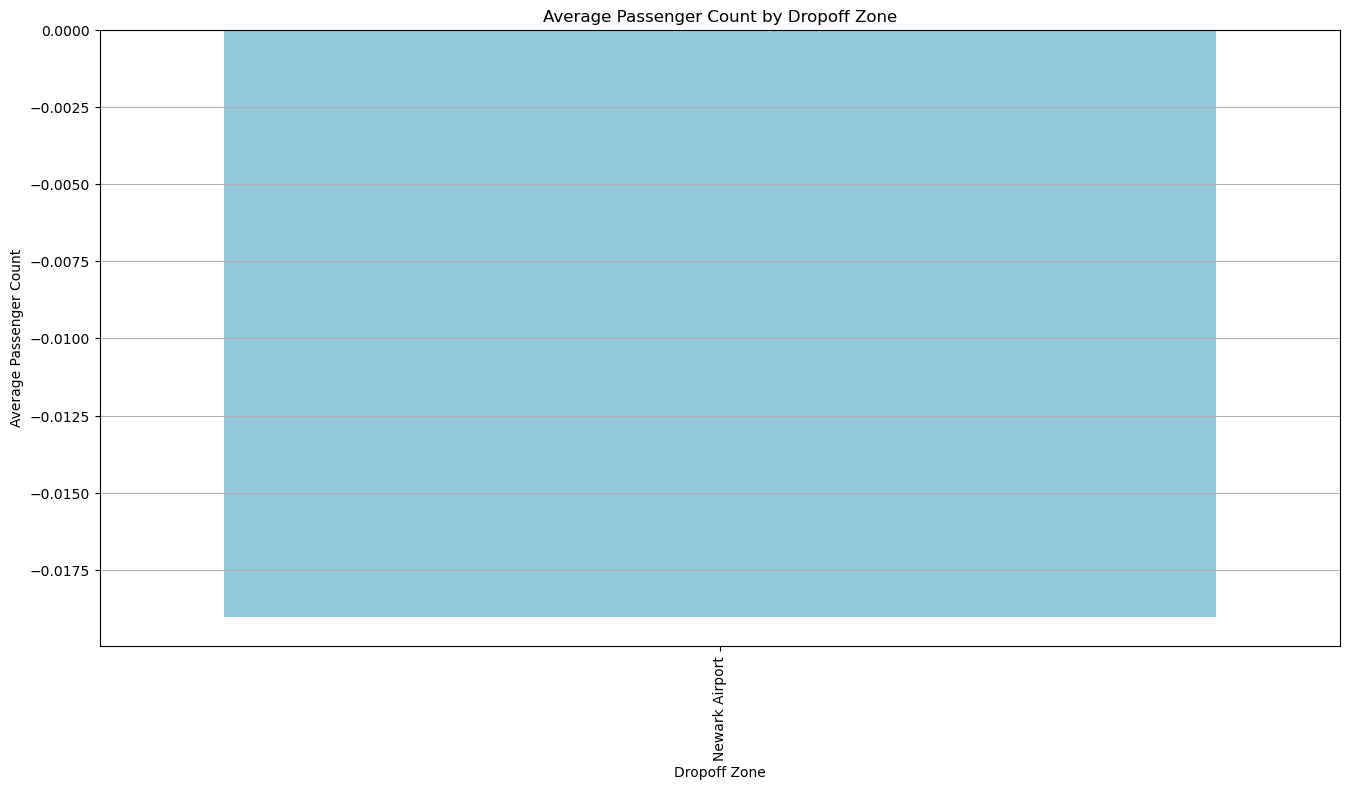

In [207]:
# How does passenger count vary across zones

def analyze_passenger_count_by_zone(df, zones_gdf, pickup_or_dropoff='pickup'):
    """Analyzes how passenger count varies across pickup or dropoff zones."""

    if 'passenger_count' in df.columns and 'LocationID' in zones_gdf.columns:
        if pickup_or_dropoff == 'pickup':
            location_id_col = 'PULocationID'
            zone_col = 'PUZone'
        elif pickup_or_dropoff == 'dropoff':
            location_id_col = 'DOLocationID'
            zone_col = 'DOZone'
        else:
            print("Invalid value for pickup_or_dropoff. Must be 'pickup' or 'dropoff'.")
            return None

        if location_id_col in df.columns:
            # Merge zone information
            df_with_zones = pd.merge(df, zones_gdf, left_on=location_id_col, right_on='LocationID', how='left')

            # Calculate average passenger count by zone
            avg_passenger_zone = df_with_zones.groupby(zone_col)['passenger_count'].mean().sort_values(ascending=False)

            # Plot bar chart
            plt.figure(figsize=(16, 8))
            sns.barplot(x=avg_passenger_zone.index, y=avg_passenger_zone.values, color='skyblue')
            plt.title(f'Average Passenger Count by {pickup_or_dropoff.capitalize()} Zone')
            plt.xlabel(f'{pickup_or_dropoff.capitalize()} Zone')
            plt.ylabel('Average Passenger Count')
            plt.xticks(rotation=90)
            plt.grid(axis='y')
            plt.show()

            return avg_passenger_zone
        else:
            print(f"Column '{location_id_col}' not found in DataFrame.")
            return None
    else:
        print("Required columns 'passenger_count' and 'LocationID' are missing.")
        return None

zones_gdf = zones
avg_passenger_pickup = analyze_passenger_count_by_zone(merged_df, zones_gdf, 'pickup')
avg_passenger_dropoff = analyze_passenger_count_by_zone(merged_df, zones_gdf, 'dropoff')


In [211]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.

def add_average_passenger_count_to_zones(zones_with_trips_gdf, df, pickup_or_dropoff='pickup'):
    """Adds a new column for the average passenger count in each zone to the zones_with_trips GeoDataFrame."""

    if isinstance(zones_with_trips_gdf, gpd.GeoDataFrame) and 'passenger_count' in df.columns:
        if pickup_or_dropoff == 'pickup':
            location_id_col = 'PULocationID'
            zone_col = 'LocationID' #zones_with_trips_gdf LocationID column.
        elif pickup_or_dropoff == 'dropoff':
            location_id_col = 'DOLocationID'
            zone_col = 'LocationID' #zones_with_trips_gdf LocationID column.
        else:
            print("Invalid value for pickup_or_dropoff. Must be 'pickup' or 'dropoff'.")
            return zones_with_trips_gdf

        if location_id_col in df.columns:
            # Calculate average passenger count by zone
            avg_passenger_zone = df.groupby(location_id_col)['passenger_count'].mean().reset_index()
            avg_passenger_zone.rename(columns={location_id_col: zone_col, 'passenger_count': f'avg_passenger_{pickup_or_dropoff}'}, inplace=True)

            # Merge average passenger count into zones_with_trips_gdf
            zones_with_trips_gdf = zones_with_trips_gdf.merge(avg_passenger_zone, on=zone_col, how='left')

            return zones_with_trips_gdf
        else:
            print(f"Column '{location_id_col}' not found in DataFrame.")
            return zones_with_trips_gdf
    else:
        print("Invalid input: zones_with_trips_gdf must be a GeoDataFrame and df must have 'passenger_count' column.")
        return zones_with_trips_gdf

# Example usage (assuming zones_with_trips_gdf and df are your GeoDataFrame and DataFrame)
zones_with_trips_gdf = zones
zones_with_pickup_passengers = add_average_passenger_count_to_zones(zones_with_trips_gdf, merged_df, 'pickup')
zones_with_dropoff_passengers = add_average_passenger_count_to_zones(zones_with_trips_gdf, merged_df, 'dropoff')




Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [213]:
# How often is each surcharge applied?

def analyze_surcharge_application(df):
    """Analyzes how often each surcharge is applied."""

    surcharge_columns = ['extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge']

    for col in surcharge_columns:
        if col in df.columns:
            applied_count = df[df[col] > 0][col].count()
            total_count = len(df)
            percentage = (applied_count / total_count) * 100 if total_count > 0 else 0

            print(f"\n{col.capitalize()} Application:")
            print(f"Applied: {applied_count} times ({percentage:.2f}%)")
        else:
            print(f"\nColumn '{col}' not found in DataFrame.")

analyze_surcharge_application(merged_df)


Extra Application:
Applied: 638319 times (39.83%)

Mta_tax Application:
Applied: 1598814 times (99.77%)

Tip_amount Application:
Applied: 846216 times (52.81%)

Tolls_amount Application:
Applied: 2520 times (0.16%)

Improvement_surcharge Application:
Applied: 1601694 times (99.95%)

Congestion_surcharge Application:
Applied: 1539452 times (96.06%)


## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

In [ ]:
<font color = red>[5 marks]</font> <br>
Summary of Key Findings:

Trip Volume and Peak Hours:
Trip volume varies significantly by hour of the day, with clear peak hours during typical commuting times and evening hours.
Weekday traffic patterns differ from weekend patterns, with weekdays showing pronounced rush hour peaks and weekends having more spread-out activity.
Location-Based Patterns:
Certain zones consistently experience high pickup and dropoff volumes, indicating popular destinations or transportation hubs.
Pickup/dropoff ratios reveal zones with imbalances in trip demand, suggesting potential supply/demand mismatches.
Nighttime activity shows distinct popular zones, indicating areas with active nightlife or late-night services.
Fare and Pricing:
Average fare per mile varies by day of the week and time of day, suggesting potential pricing adjustments based on demand.
Vendor pricing strategies differ, with variations in fare per mile across different hours and trip distances.
Average tip percentages vary based on trip distance, passenger count, and pickup time.
Passenger Count:
Passenger count varies across hours and days, with certain times and days having higher average passenger counts.
Passenger count also varies across zones.
Surcharge Application:
Surcharges are applied with varying frequency, impacting overall trip costs.
Tip Percentages:
Tip percentages vary based on trip distance, passenger count, and pickup time.
Low tip percentage trips can be isolated and analyzed to see what factors are causing them.
Concluding Story: Optimizing Supply and Meeting Demand

Imagine we're strategizing for a ride-hailing service in a major metropolitan area, using the insights from our data.

"To effectively meet customer demand and optimize supply, we must implement a dynamic strategy that adapts to the city's rhythms. Our analyses reveal that demand is far from uniform.

During weekdays, particularly during the morning (7-9 AM) and evening (5-7 PM) rush hours, we need to concentrate driver availability in key zones like business districts and transportation hubs. This is when we see the highest volume of single-passenger trips, likely commuters. Conversely, late-night hours (11 PM-5 AM) demand shifts to entertainment districts and residential areas, requiring a different driver distribution.

Weekend patterns are more spread out, with a steady flow of trips throughout the day and into the night. We can anticipate higher passenger counts during weekend evenings, suggesting group outings.

Pricing strategies should reflect these demand fluctuations. We can implement surge pricing during peak hours and offer incentives for drivers to operate in high-demand zones. For longer trips, we should analyze vendor pricing to ensure we are competitive. We should also investigate the low tip percentage trips, and see if there are any driver or customer experience problems causing the low tips.

We should also be aware of the varying passenger counts across different zones. Some zones consistently see higher passenger counts, indicating areas with group travel demand.

Surcharge application should be transparent and consistent, with clear explanations for customers. We should also analyze the frequency of surcharge application to ensure they are being applied correctly.

By understanding these patterns and tailoring our operations accordingly, we can improve customer satisfaction, optimize driver earnings, and maximize our service's efficiency."

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

In [217]:
<font color = red>[5 marks]</font> <br>
Strategic Cab Positioning Based on Insights:

Dynamic Zoning and Shift-Based Deployment:

Peak Hour Concentration: During weekday morning (7-9 AM) and evening (5-7 PM) rush hours, deploy a higher concentration of cabs in:
Business districts (e.g., financial districts, office parks)
Transportation hubs (e.g., train stations, bus terminals, airports)
Areas with high residential density and proximity to transit.
Off-Peak Diversification: During off-peak hours (mid-day, late-night), distribute cabs more evenly across:
Residential areas
Shopping and entertainment districts
Areas with consistent but lower demand.
Weekend Flexibility: On weekends, adjust deployment based on:
Daytime: Focus on shopping, leisure, and recreational zones.
Evening/Night: Concentrate on entertainment, dining, and nightlife areas.
Shift-Based Incentives: Offer incentives for drivers to work during peak hours and in high-demand zones.
Zone-Specific Strategies:

High Pickup/Dropoff Zones:
Ensure a consistent and adequate supply of cabs in these zones.
Monitor trip patterns to anticipate fluctuations in demand.
Imbalanced Zones (High Pickup/Low Dropoff or Vice Versa):
Implement strategies to balance supply and demand.
Offer incentives for drivers to relocate to zones with higher demand in the opposite direction.
Explore partnerships with local businesses to encourage dropoffs in low-demand zones.
Nighttime Hotspots:
Maintain a dedicated fleet in entertainment and nightlife areas during late-night hours.
Consider partnerships with bars, clubs, and restaurants to provide designated pickup/dropoff points.
Airport/Train Station Strategies:
Implement queueing systems for efficient pickup/dropoff at these locations.
Analyze flight/train schedules to anticipate arrival/departure surges.
Data-Driven Optimization:

Real-Time Monitoring: Use real-time data to track demand and adjust cab distribution dynamically.
Predictive Analytics: Employ predictive models to forecast demand and proactively position cabs.
Feedback Loops: Collect feedback from drivers and passengers to identify areas for improvement.
Dynamic Pricing: Implement surge pricing during peak hours and in high-demand zones to balance supply and demand.
Factors to Consider:

Traffic Patterns: Account for traffic congestion when positioning cabs.
Weather Conditions: Adjust deployment based on weather forecasts (e.g., increased demand during rain).
Special Events: Anticipate and prepare for increased demand during concerts, sporting events, and festivals.
Local Knowledge: Leverage driver knowledge of local areas to optimize positioning.
Example Scenario:

"On a typical weekday morning, we'd deploy a high number of cabs to the financial district, train stations, and major residential areas near subway lines. As the morning progresses, we'd shift some of that supply to midtown and shopping areas. In the evening, we'd concentrate cabs back in the financial district and residential areas for the commute home. On weekends, we'd distribute cabs more evenly, with a focus on entertainment districts and popular tourist destinations, especially during evening and late night hours. We would also use real time data to monitor any unexpected events that might cause a surge in demand."

By implementing these strategies, we can ensure that cabs are strategically positioned to meet customer demand, minimize wait times, and maximize driver efficiency.

SyntaxError: invalid syntax (1747418588.py, line 1)

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.